In [1]:
# ============================================
# BLOCK 0: Imports + Paths + Device + Seed
# ============================================

from __future__ import annotations

import os
import json
import time
import math
import random
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# -----------------------------
# librosa (required for CQT/HCQT)
# -----------------------------
try:
    import librosa
except Exception as e:
    raise ImportError(
        "librosa is required.\n"
        "Install in TERMINAL:\n"
        "  python -m pip install --user librosa soundfile\n"
        "Then restart kernel."
    ) from e

try:
    from tqdm import tqdm
except Exception:
    tqdm = lambda x, **kwargs: x


# -----------------------------
# Paths (your existing setup)
# -----------------------------
WORK_DIR = Path("/home/jovyan/work")
SMALL_ROOT = WORK_DIR / "musicnet_small"

TRAIN_AUDIO_DIR = SMALL_ROOT / "train_data"
TRAIN_LABEL_DIR = SMALL_ROOT / "train_labels"
TEST_AUDIO_DIR  = SMALL_ROOT / "test_data"
TEST_LABEL_DIR  = SMALL_ROOT / "test_labels"

META_PATH = SMALL_ROOT / "musicnet_metadata.csv"

# Large shared output volume
OUT_ROOT = Path("/home/jovyan/shared/musicnet_experiments_ctc")  # new root to keep experiments tidy
OUT_ROOT.mkdir(parents=True, exist_ok=True)

FIG_DIR  = OUT_ROOT / "figures"
CKPT_DIR = OUT_ROOT / "checkpoints"
FIG_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

SPLITS_PATH = OUT_ROOT / "splits.json"
VOCAB_PATH  = OUT_ROOT / "vocab_info.json"


# -----------------------------
# Device
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True  # faster convs for fixed shapes

# -----------------------------
# DataLoader defaults
# -----------------------------
NUM_WORKERS = 4
PIN_MEMORY = (DEVICE == "cuda")
print("NUM_WORKERS:", NUM_WORKERS, "PIN_MEMORY:", PIN_MEMORY)

# -----------------------------
# Reproducibility (seeded runs)
# -----------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# sanity checks
assert TRAIN_AUDIO_DIR.exists() and TRAIN_LABEL_DIR.exists()
assert TEST_AUDIO_DIR.exists() and TEST_LABEL_DIR.exists()
assert META_PATH.exists()


DEVICE: cuda
CUDA available: True
GPU: NVIDIA A30 MIG 4g.24gb
NUM_WORKERS: 4 PIN_MEMORY: True


In [2]:
# ============================================
# BLOCK 1: Load metadata + integrity checks + index_df
# ============================================

def list_wavs(d: Path) -> List[Path]:
    return sorted(d.glob("*.wav"))

def list_csvs(d: Path) -> List[Path]:
    return sorted(d.glob("*.csv"))

def stems(files: List[Path]) -> List[str]:
    return [f.stem for f in files]

meta = pd.read_csv(META_PATH)
meta["id"] = meta["id"].astype(int)

train_wavs = list_wavs(TRAIN_AUDIO_DIR)
train_csvs = list_csvs(TRAIN_LABEL_DIR)
test_wavs  = list_wavs(TEST_AUDIO_DIR)
test_csvs  = list_csvs(TEST_LABEL_DIR)

print("Train wav:", len(train_wavs), "Train labels:", len(train_csvs))
print("Test  wav:", len(test_wavs),  "Test  labels:", len(test_csvs))

train_wav_ids = set(stems(train_wavs))
train_lbl_ids = set(stems(train_csvs))
test_wav_ids  = set(stems(test_wavs))
test_lbl_ids  = set(stems(test_csvs))

print("Train missing labels:", sorted(train_wav_ids - train_lbl_ids)[:10])
print("Train missing audio :", sorted(train_lbl_ids - train_wav_ids)[:10])
print("Test missing labels :", sorted(test_wav_ids - test_lbl_ids)[:10])
print("Test missing audio  :", sorted(test_lbl_ids - test_wav_ids)[:10])

assert train_wav_ids == train_lbl_ids, "Train audio/labels mismatch"
assert test_wav_ids  == test_lbl_ids,  "Test audio/labels mismatch"
print("OK: Audio and label IDs match.")

def make_index(wav_dir: Path, lbl_dir: Path, split: str) -> pd.DataFrame:
    rows = []
    for w in sorted(wav_dir.glob("*.wav")):
        tid = int(w.stem)
        lp = lbl_dir / f"{w.stem}.csv"
        rows.append({
            "split": split,
            "id": tid,
            "audio_path": str(w),
            "label_path": str(lp),
        })
    return pd.DataFrame(rows)

train_index = make_index(TRAIN_AUDIO_DIR, TRAIN_LABEL_DIR, "train_pool")
test_index  = make_index(TEST_AUDIO_DIR,  TEST_LABEL_DIR,  "test")
index_df = pd.concat([train_index, test_index], ignore_index=True)

index_df = index_df.merge(meta, on="id", how="left")
print("Index rows:", len(index_df))
print(index_df["split"].value_counts())
print("Metadata coverage composer:", float(index_df["composer"].notna().mean()))
display(index_df[["id","split","composer","composition","movement","ensemble","seconds"]].head(10))


Train wav: 40 Train labels: 40
Test  wav: 10 Test  labels: 10
Train missing labels: []
Train missing audio : []
Test missing labels : []
Test missing audio  : []
OK: Audio and label IDs match.
Index rows: 50
split
train_pool    40
test          10
Name: count, dtype: int64
Metadata coverage composer: 1.0


,id,split,composer,composition,movement,ensemble,seconds
0,2156,train_pool,Brahms,String Sextet No 1 in B-flat major,3. Scherzo. Allegro molto,String Sextet,192
1,2194,train_pool,Bach,"WTK I, No. 13: Prelude and Fugue in F-sharp major",1. Prelude,Solo Piano,100
2,2195,train_pool,Bach,"WTK I, No. 3: Prelude and Fugue in C-sharp major",2. Fugue,Solo Piano,155
3,2196,train_pool,Bach,"WTK I, No. 3: Prelude and Fugue in C-sharp major",1. Prelude,Solo Piano,75
4,2200,train_pool,Bach,"WTK I, No. 16: Prelude and Fugue in G minor",2. Fugue,Solo Piano,113
5,2201,train_pool,Bach,"WTK I, No. 16: Prelude and Fugue in G minor",1. Prelude,Solo Piano,134
6,2207,train_pool,Bach,"WTK I, No. 10: Prelude and Fugue in E minor",2. Fugue,Solo Piano,89
7,2208,train_pool,Bach,"WTK I, No. 10: Prelude and Fugue in E minor",1. Prelude,Solo Piano,120
8,2209,train_pool,Bach,"WTK I, No. 4: Prelude and Fugue in C-sharp minor",2. Fugue,Solo Piano,160
9,2213,train_pool,Bach,"WTK I, No. 2: Prelude and Fugue in C minor",2. Fugue,Solo Piano,115


In [3]:
# ============================================
# BLOCK 2: Train/Val split (work-disjoint), Test = existing folder
# ============================================

TRAIN_POOL_IDS = sorted([int(p.stem) for p in TRAIN_AUDIO_DIR.glob("*.wav")])
TEST_IDS       = sorted([int(p.stem) for p in TEST_AUDIO_DIR.glob("*.wav")])
assert len(set(TRAIN_POOL_IDS) & set(TEST_IDS)) == 0, "Train/test overlap!"

print("Train pool tracks:", len(TRAIN_POOL_IDS))
print("Test tracks:", len(TEST_IDS))

N_VAL = 8
assert len(TRAIN_POOL_IDS) == 40 and len(TEST_IDS) == 10, "Expected 40 + 10"

def work_key(row: pd.Series) -> Tuple[str, str]:
    return (str(row["composer"]).strip(), str(row["composition"]).strip())

def make_val_split(meta_df: pd.DataFrame, train_pool_ids: List[int], n_val: int, seed: int):
    rng = random.Random(seed)
    df = meta_df[meta_df["id"].isin(train_pool_ids)].copy()
    df["composer"] = df["composer"].fillna("UNKNOWN_COMPOSER")
    df["composition"] = df["composition"].fillna(df["id"].apply(lambda x: f"id_{x}"))
    df["work_key"] = df.apply(work_key, axis=1)

    groups = df.groupby("work_key")["id"].apply(list).tolist()
    groups.sort(key=len)
    rng.shuffle(groups)

    val_ids = []
    for g in groups:
        if len(val_ids) + len(g) <= n_val:
            val_ids.extend(g)
        if len(val_ids) == n_val:
            break

    if len(val_ids) < n_val:
        remaining = [tid for tid in train_pool_ids if tid not in val_ids]
        rng.shuffle(remaining)
        val_ids.extend(remaining[:(n_val - len(val_ids))])

    val_ids = sorted(set(val_ids))
    train_ids = sorted([tid for tid in train_pool_ids if tid not in val_ids])

    # leakage check
    tv = meta_df[meta_df["id"].isin(train_ids + val_ids)].copy()
    tv["composer"] = tv["composer"].fillna("UNKNOWN_COMPOSER")
    tv["composition"] = tv["composition"].fillna(tv["id"].apply(lambda x: f"id_{x}"))
    tv["work_key"] = tv.apply(work_key, axis=1)

    train_works = set(tv[tv["id"].isin(train_ids)]["work_key"])
    val_works   = set(tv[tv["id"].isin(val_ids)]["work_key"])
    print("Work leakage count (ideal 0):", len(train_works & val_works))

    assert len(val_ids) == n_val
    assert len(set(train_ids) & set(val_ids)) == 0
    return train_ids, val_ids

# One canonical split file for all experiments (fixed)
train_ids, val_ids = make_val_split(meta, TRAIN_POOL_IDS, n_val=N_VAL, seed=42)

splits = {"train_ids": train_ids, "val_ids": val_ids, "test_ids": TEST_IDS}
with open(SPLITS_PATH, "w", encoding="utf-8") as f:
    json.dump(splits, f, indent=2)

print("Saved:", SPLITS_PATH)
print("Train:", len(train_ids), "Val:", len(val_ids), "Test:", len(TEST_IDS))
print("Val IDs:", val_ids)


Train pool tracks: 40
Test tracks: 10
Work leakage count (ideal 0): 0
Saved: /home/jovyan/shared/musicnet_experiments_ctc/splits.json
Train: 32 Val: 8 Test: 10
Val IDs: [2156, 2213, 2214, 2215, 2224, 2239, 2240, 2358]


In [4]:
# ============================================
# BLOCK 3: Labels + Pitch-only vocab + special tokens
# ============================================

def read_label_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = {"start_time", "end_time", "instrument", "note"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{path} missing columns: {missing}")
    df = df.copy()
    df["start_time"] = df["start_time"].astype(int)
    df["end_time"] = df["end_time"].astype(int)
    df["instrument"] = df["instrument"].astype(int)
    df["note"] = df["note"].astype(int)
    return df

MIN_NOTE = 21
MAX_NOTE = 108
N_PITCH = MAX_NOTE - MIN_NOTE + 1  # 88

def note_to_id(note: int) -> int:
    if note < MIN_NOTE or note > MAX_NOTE:
        raise ValueError(f"Note out of range: {note}")
    return note - MIN_NOTE

def id_to_note(tid: int) -> int:
    return tid + MIN_NOTE

PAD_ID       = N_PITCH
CTC_BLANK_ID = N_PITCH + 1
SOS_ID       = N_PITCH + 2
EOS_ID       = N_PITCH + 3
TOTAL_VOCAB_SIZE = N_PITCH + 4

vocab_info = {
    "type": "pitch_only",
    "min_note": MIN_NOTE, "max_note": MAX_NOTE, "N_PITCH": N_PITCH,
    "PAD_ID": PAD_ID, "CTC_BLANK_ID": CTC_BLANK_ID, "SOS_ID": SOS_ID, "EOS_ID": EOS_ID,
    "TOTAL_VOCAB_SIZE": TOTAL_VOCAB_SIZE
}
with open(VOCAB_PATH, "w", encoding="utf-8") as f:
    json.dump(vocab_info, f, indent=2)

print("TOTAL_VOCAB_SIZE:", TOTAL_VOCAB_SIZE, "| Specials:", {"PAD": PAD_ID, "BLANK": CTC_BLANK_ID, "SOS": SOS_ID, "EOS": EOS_ID})
print("Saved:", VOCAB_PATH)


TOTAL_VOCAB_SIZE: 92 | Specials: {'PAD': 88, 'BLANK': 89, 'SOS': 90, 'EOS': 91}
Saved: /home/jovyan/shared/musicnet_experiments_ctc/vocab_info.json


CQT: (252, 862) (F,T)
HCQT: (5, 252, 862) (C,F,T) harmonics: (0.5, 1.0, 2.0, 3.0, 4.0)


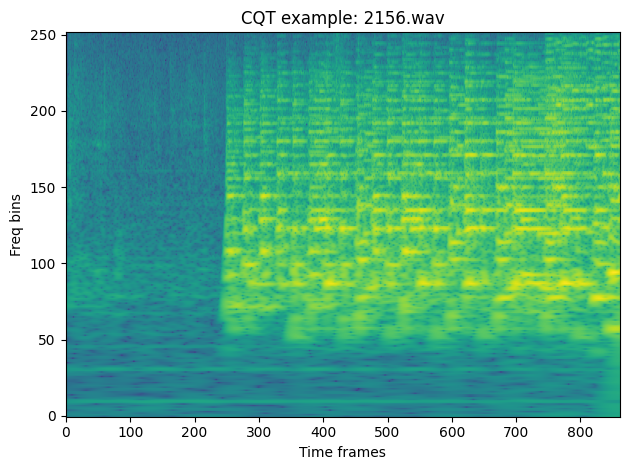

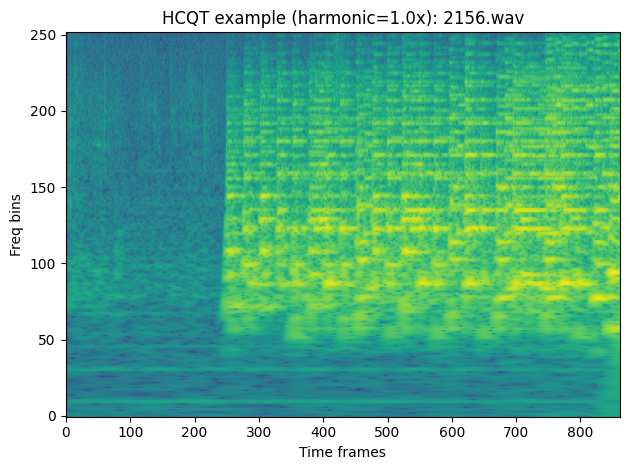

In [5]:
# ============================================
# BLOCK 4: Feature configs and computation (CQT vs HCQT)
# ============================================

@dataclass
class PreprocConfig:
    sr: int = 44100
    mono: bool = True
    seg_seconds: float = 10.0
    hop_seconds: float = 5.0
    hop_length: int = 512
    bins_per_octave: int = 36
    n_bins: int = 252
    fmin: float = 32.7031956626  # C1
    log_eps: float = 1e-6
    normalize: bool = True

# HCQT config: number of harmonics, and their multipliers
@dataclass
class HCQTConfig:
    harmonics: Tuple[float, ...] = (0.5, 1.0, 2.0, 3.0, 4.0)  # common simple set
    # You keep same CQT params; only fmin scales with harmonic

CFG = PreprocConfig()
HCFG = HCQTConfig()

def compute_cqt(y: np.ndarray, cfg: PreprocConfig) -> np.ndarray:
    C = librosa.cqt(
        y=y, sr=cfg.sr, hop_length=cfg.hop_length,
        fmin=cfg.fmin, n_bins=cfg.n_bins, bins_per_octave=cfg.bins_per_octave
    )
    X = np.log(np.abs(C).astype(np.float32) + cfg.log_eps)
    if cfg.normalize:
        X = (X - X.mean()) / (X.std() + 1e-8)
    return X.astype(np.float32)  # (F,T)

def compute_hcqt(y: np.ndarray, cfg: PreprocConfig, hcfg: HCQTConfig) -> np.ndarray:
    # Returns (C,F,T) where C=len(harmonics)
    Xs = []
    for h in hcfg.harmonics:
        fmin_h = cfg.fmin * float(h)
        C = librosa.cqt(
            y=y, sr=cfg.sr, hop_length=cfg.hop_length,
            fmin=fmin_h, n_bins=cfg.n_bins, bins_per_octave=cfg.bins_per_octave
        )
        X = np.log(np.abs(C).astype(np.float32) + cfg.log_eps)
        Xs.append(X)
    X = np.stack(Xs, axis=0)  # (C,F,T)
    if cfg.normalize:
        # normalize globally across channels
        X = (X - X.mean()) / (X.std() + 1e-8)
    return X.astype(np.float32)

# Quick visual: CQT and HCQT (channel 1.0)
example_wav = train_wavs[0]
y, _ = librosa.load(example_wav, sr=CFG.sr, mono=CFG.mono)
seg_len = int(CFG.seg_seconds * CFG.sr)

Xc = compute_cqt(y[:seg_len], CFG)
Xh = compute_hcqt(y[:seg_len], CFG, HCFG)

print("CQT:", Xc.shape, "(F,T)")
print("HCQT:", Xh.shape, "(C,F,T) harmonics:", HCFG.harmonics)

plt.figure()
plt.imshow(Xc, aspect="auto", origin="lower")
plt.title(f"CQT example: {example_wav.name}")
plt.xlabel("Time frames"); plt.ylabel("Freq bins")
plt.tight_layout()
plt.savefig(FIG_DIR / "feat_cqt_example.png", dpi=160)
plt.show()

plt.figure()
plt.imshow(Xh[1], aspect="auto", origin="lower")  # harmonic=1.0 is index 1 if (0.5,1.0,...)
plt.title(f"HCQT example (harmonic={HCFG.harmonics[1]}x): {example_wav.name}")
plt.xlabel("Time frames"); plt.ylabel("Freq bins")
plt.tight_layout()
plt.savefig(FIG_DIR / "feat_hcqt_example.png", dpi=160)
plt.show()


In [6]:
# ============================================
# BLOCK 5: Precompute segments for CQT and HCQT (cached)
# ============================================

CQT_DIR  = OUT_ROOT / "cqt_npz"
HCQT_DIR = OUT_ROOT / "hcqt_npz"
CQT_DIR.mkdir(parents=True, exist_ok=True)
HCQT_DIR.mkdir(parents=True, exist_ok=True)

MANIFEST_CQT  = OUT_ROOT / "manifest_cqt.csv"
MANIFEST_HCQT = OUT_ROOT / "manifest_hcqt.csv"

def events_to_token_sequence_pitch_only(events_df: pd.DataFrame, seg_start_samp: int, seg_end_samp: int) -> List[int]:
    df = events_df[(events_df["start_time"] >= seg_start_samp) & (events_df["start_time"] < seg_end_samp)].copy()
    if len(df) == 0:
        return []
    df["rel_start"] = df["start_time"] - seg_start_samp
    df = df.sort_values(["rel_start", "note"], ascending=[True, True])

    toks = []
    for n in df["note"].values:
        n = int(n)
        if MIN_NOTE <= n <= MAX_NOTE:
            toks.append(note_to_id(n))

    # compress immediate repeats
    out = []
    prev = None
    for t in toks:
        if t != prev:
            out.append(t)
        prev = t
    return out

def build_index_df_simple() -> pd.DataFrame:
    rows = []
    for w in train_wavs:
        tid = int(w.stem)
        rows.append({"id": tid, "audio_path": str(w), "label_path": str(TRAIN_LABEL_DIR / f"{tid}.csv")})
    for w in test_wavs:
        tid = int(w.stem)
        rows.append({"id": tid, "audio_path": str(w), "label_path": str(TEST_LABEL_DIR / f"{tid}.csv")})
    return pd.DataFrame(rows)

index_df_simple = build_index_df_simple()

def precompute_feature_npz(
    feature_type: str,
    out_dir: Path,
    manifest_path: Path,
    cfg: PreprocConfig,
    hcfg: Optional[HCQTConfig],
    splits: Dict[str, List[int]],
) -> pd.DataFrame:
    """
    feature_type: "cqt" or "hcqt"
    Saves per-segment .npz with:
      - X: float16
          CQT: (F,T)
          HCQT:(C,F,T)
      - y: int32 (L,)
      - meta: json string with segment info for later analysis/visuals
    """
    if manifest_path.exists():
        print(f"[CACHE] Using existing manifest: {manifest_path}")
        return pd.read_csv(manifest_path)

    seg_len_samp = int(cfg.seg_seconds * cfg.sr)
    hop_len_samp = int(cfg.hop_seconds * cfg.sr)

    id_to_split = {int(t): "train" for t in splits["train_ids"]}
    id_to_split.update({int(t): "val" for t in splits["val_ids"]})
    id_to_split.update({int(t): "test" for t in splits["test_ids"]})

    use_df = index_df_simple[index_df_simple["id"].isin(id_to_split.keys())].copy()
    print("Tracks used:", len(use_df), "| feature:", feature_type)

    rows = []
    for _, r in tqdm(use_df.iterrows(), total=len(use_df), desc=f"Precompute {feature_type.upper()}"):
        tid = int(r["id"])
        split = id_to_split[tid]
        audio_path = Path(r["audio_path"])
        label_path = Path(r["label_path"])

        y_audio, _ = librosa.load(audio_path, sr=cfg.sr, mono=cfg.mono)
        events = read_label_csv(label_path)

        total_samp = len(y_audio)
        save_idx = 0

        for seg_start in range(0, max(1, total_samp - seg_len_samp + 1), hop_len_samp):
            seg_end = seg_start + seg_len_samp
            if seg_end > total_samp:
                break

            tok = events_to_token_sequence_pitch_only(events, seg_start, seg_end)
            if len(tok) == 0:
                continue

            if feature_type == "cqt":
                X = compute_cqt(y_audio[seg_start:seg_end], cfg)      # (F,T)
            elif feature_type == "hcqt":
                assert hcfg is not None
                X = compute_hcqt(y_audio[seg_start:seg_end], cfg, hcfg)  # (C,F,T)
            else:
                raise ValueError("feature_type must be 'cqt' or 'hcqt'")

            npz_path = out_dir / f"{split}_id{tid}_seg{save_idx:05d}.npz"

            meta_out = {
                "track_id": tid, "split": split,
                "audio_path": str(audio_path), "label_path": str(label_path),
                "seg_start_samp": int(seg_start), "seg_end_samp": int(seg_end),
                "sr": cfg.sr, "hop_length": cfg.hop_length,
                "bins_per_octave": cfg.bins_per_octave, "n_bins": cfg.n_bins, "fmin": cfg.fmin,
                "token_type": "pitch_only", "min_note": MIN_NOTE, "max_note": MAX_NOTE,
                "feature_type": feature_type,
                "hcqt_harmonics": (list(hcfg.harmonics) if hcfg else None),
            }

            np.savez_compressed(
                npz_path,
                X=X.astype(np.float16),
                y=np.asarray(tok, dtype=np.int32),
                meta=json.dumps(meta_out),
            )

            # frames
            if feature_type == "cqt":
                n_frames = int(X.shape[1])
            else:
                n_frames = int(X.shape[2])

            rows.append({
                "split": split,
                "track_id": tid,
                "seg_idx": save_idx,
                "npz_path": str(npz_path),
                "n_frames": n_frames,
                "n_tokens": int(len(tok)),
                "feature_type": feature_type,
            })
            save_idx += 1

    manifest = pd.DataFrame(rows)
    manifest.to_csv(manifest_path, index=False)
    print("Saved manifest:", manifest_path, "| rows:", len(manifest))
    print(manifest["split"].value_counts())

    return manifest

# Ensure fixed splits loaded from file if already present
if SPLITS_PATH.exists():
    splits = json.loads(Path(SPLITS_PATH).read_text(encoding="utf-8"))

manifest_cqt  = precompute_feature_npz("cqt",  CQT_DIR,  MANIFEST_CQT,  CFG, None, splits)
manifest_hcqt = precompute_feature_npz("hcqt", HCQT_DIR, MANIFEST_HCQT, CFG, HCFG, splits)

display(manifest_cqt.head())
display(manifest_hcqt.head())


[CACHE] Using existing manifest: /home/jovyan/shared/musicnet_experiments_ctc/manifest_cqt.csv
[CACHE] Using existing manifest: /home/jovyan/shared/musicnet_experiments_ctc/manifest_hcqt.csv


,split,track_id,seg_idx,npz_path,n_frames,n_tokens,feature_type
0,val,2156,0,/home/jovyan/shared/musicnet_experiments_ctc/c...,862,88,cqt
1,val,2156,1,/home/jovyan/shared/musicnet_experiments_ctc/c...,862,135,cqt
2,val,2156,2,/home/jovyan/shared/musicnet_experiments_ctc/c...,862,126,cqt
3,val,2156,3,/home/jovyan/shared/musicnet_experiments_ctc/c...,862,137,cqt
4,val,2156,4,/home/jovyan/shared/musicnet_experiments_ctc/c...,862,153,cqt


,split,track_id,seg_idx,npz_path,n_frames,n_tokens,feature_type
0,val,2156,0,/home/jovyan/shared/musicnet_experiments_ctc/h...,862,88,hcqt
1,val,2156,1,/home/jovyan/shared/musicnet_experiments_ctc/h...,862,135,hcqt
2,val,2156,2,/home/jovyan/shared/musicnet_experiments_ctc/h...,862,126,hcqt
3,val,2156,3,/home/jovyan/shared/musicnet_experiments_ctc/h...,862,137,hcqt
4,val,2156,4,/home/jovyan/shared/musicnet_experiments_ctc/h...,862,153,hcqt


Token-length percentiles: {
  "train": {
    "p50": 93.5,
    "p75": 120.0,
    "p90": 175.30000000000007,
    "p95": 208.29999999999995,
    "p99": 314.1199999999999,
    "p100": 366.0
  },
  "val": {
    "p50": 90.5,
    "p75": 121.0,
    "p90": 183.0,
    "p95": 202.75,
    "p99": 230.60000000000002,
    "p100": 234.0
  },
  "test": {
    "p50": 86.5,
    "p75": 109.0,
    "p90": 138.0,
    "p95": 153.60000000000014,
    "p99": 233.0,
    "p100": 241.0
  }
}
Train before: 698 after: 635
Val: 186 Test: 280


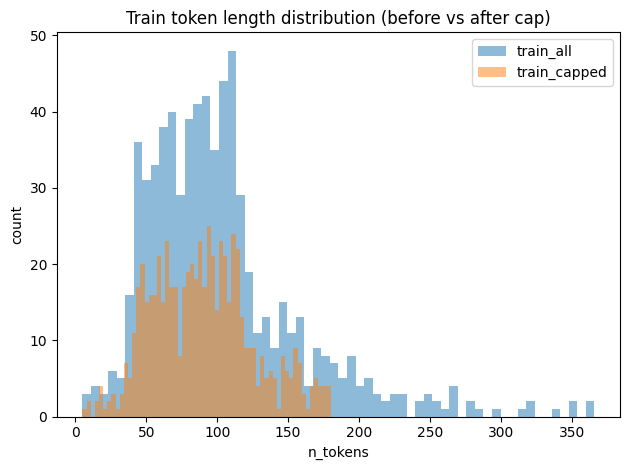

Token-length percentiles: {
  "train": {
    "p50": 93.5,
    "p75": 120.0,
    "p90": 175.30000000000007,
    "p95": 208.29999999999995,
    "p99": 314.1199999999999,
    "p100": 366.0
  },
  "val": {
    "p50": 90.5,
    "p75": 121.0,
    "p90": 183.0,
    "p95": 202.75,
    "p99": 230.60000000000002,
    "p100": 234.0
  },
  "test": {
    "p50": 86.5,
    "p75": 109.0,
    "p90": 138.0,
    "p95": 153.60000000000014,
    "p99": 233.0,
    "p100": 241.0
  }
}
Train before: 698 after: 635
Val: 186 Test: 280


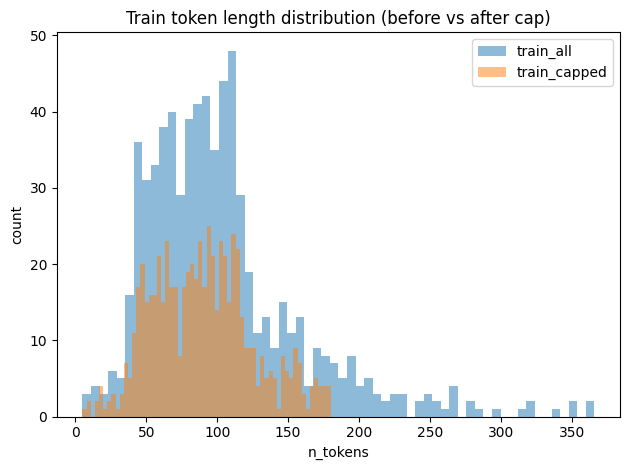

In [7]:
# ============================================
# BLOCK 5b: Token length cap (training-only)
# ============================================

def apply_train_token_cap(manifest: pd.DataFrame, max_tokens_train: int = 180):
    def perc(arr):
        ps = [50, 75, 90, 95, 99, 100]
        return {f"p{p}": float(np.percentile(arr, p)) for p in ps}

    out = {}
    for sp in ["train", "val", "test"]:
        a = manifest[manifest["split"] == sp]["n_tokens"].values
        out[sp] = perc(a)

    print("Token-length percentiles:", json.dumps(out, indent=2))

    train_manifest = manifest[(manifest["split"]=="train") & (manifest["n_tokens"] <= max_tokens_train)].reset_index(drop=True)
    val_manifest   = manifest[(manifest["split"]=="val")].reset_index(drop=True)
    test_manifest  = manifest[(manifest["split"]=="test")].reset_index(drop=True)

    print("Train before:", int((manifest["split"]=="train").sum()), "after:", len(train_manifest))
    print("Val:", len(val_manifest), "Test:", len(test_manifest))

    # plot
    plt.figure()
    plt.hist(manifest[manifest["split"]=="train"]["n_tokens"], bins=60, alpha=0.5, label="train_all")
    plt.hist(train_manifest["n_tokens"], bins=60, alpha=0.5, label="train_capped")
    plt.title("Train token length distribution (before vs after cap)")
    plt.xlabel("n_tokens"); plt.ylabel("count"); plt.legend()
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"train_tokens_cap_{manifest['feature_type'].iloc[0]}.png", dpi=160)
    plt.show()

    return train_manifest, val_manifest, test_manifest

MAX_TOKENS_TRAIN = 180
train_cqt, val_cqt, test_cqt = apply_train_token_cap(manifest_cqt, max_tokens_train=MAX_TOKENS_TRAIN)
train_hcqt, val_hcqt, test_hcqt = apply_train_token_cap(manifest_hcqt, max_tokens_train=MAX_TOKENS_TRAIN)


In [8]:
# ============================================
# BLOCK 6: Feature-level augmentation (toggleable)
# ============================================

@dataclass
class AugmentConfig:
    enabled: bool = False
    # bin shifts
    freq_shift_bins_max: int = 2      # small tuning-like shift
    semitone_shift_max: int = 5       # approximate transposition as larger bin shift
    # noise
    noise_std: float = 0.02
    p_noise: float = 0.5
    # SpecAugment
    p_specaug: float = 0.5
    time_mask_max: int = 40           # frames
    freq_mask_max: int = 24           # bins
    n_time_masks: int = 2
    n_freq_masks: int = 2

AUG_DEFAULT = AugmentConfig(enabled=False)

def _rand_int(rng: np.random.RandomState, lo: int, hi: int) -> int:
    return int(rng.randint(lo, hi+1))

def apply_specaugment(X: np.ndarray, rng: np.random.RandomState, cfg: AugmentConfig) -> np.ndarray:
    """
    X is either:
      - CQT:  (T,F)
      - HCQT: (T,C,F)  (we'll standardize to this shape in dataset)
    We apply masks over time and frequency dims; for HCQT, mask is applied to all channels.
    """
    T = X.shape[0]
    # freq dimension last
    Fdim = X.shape[-1]

    # time masks
    for _ in range(cfg.n_time_masks):
        w = _rand_int(rng, 0, cfg.time_mask_max)
        if w <= 0: 
            continue
        t0 = _rand_int(rng, 0, max(0, T - w))
        X[t0:t0+w, ...] = 0.0

    # freq masks
    for _ in range(cfg.n_freq_masks):
        w = _rand_int(rng, 0, cfg.freq_mask_max)
        if w <= 0: 
            continue
        f0 = _rand_int(rng, 0, max(0, Fdim - w))
        X[..., f0:f0+w] = 0.0

    return X

def apply_feature_augmentation(X: np.ndarray, rng: np.random.RandomState, cfg: AugmentConfig) -> np.ndarray:
    """
    Standard input format expected here: X is (T,F) or (T,C,F).
    """
    if not cfg.enabled:
        return X

    # 1) tuning-like small freq shift
    if cfg.freq_shift_bins_max > 0:
        shift = _rand_int(rng, -cfg.freq_shift_bins_max, cfg.freq_shift_bins_max)
        if shift != 0:
            X = np.roll(X, shift=shift, axis=-1)

    # 2) larger "semitone-like" shift (approx)
    if cfg.semitone_shift_max > 0:
        shift2 = _rand_int(rng, -cfg.semitone_shift_max, cfg.semitone_shift_max)
        if shift2 != 0:
            X = np.roll(X, shift=shift2, axis=-1)

    # 3) noise
    if rng.rand() < cfg.p_noise and cfg.noise_std > 0:
        X = X + rng.randn(*X.shape).astype(np.float32) * float(cfg.noise_std)

    # 4) specaugment
    if rng.rand() < cfg.p_specaug:
        X = apply_specaugment(X, rng, cfg)

    return X.astype(np.float32)


In [9]:
# ============================================
# BLOCK 7: Dataset + Collate + DataLoaders (supports CQT and HCQT)
# ============================================

class MusicNetSegmentDataset(Dataset):
    def __init__(self, manifest_df: pd.DataFrame, augment: AugmentConfig, seed: int):
        self.df = manifest_df.reset_index(drop=True)
        self.augment = augment
        self.seed = seed

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        z = np.load(row["npz_path"], allow_pickle=False)

        Xraw = z["X"].astype(np.float32)
        y = torch.from_numpy(z["y"].astype(np.int64))
        meta = json.loads(z["meta"].item())

        # deterministic per-sample augmentation randomness:
        # (seed + idx) makes runs reproducible for a given seed
        rng = np.random.RandomState(self.seed + idx)

        # standardize to:
        # CQT:  X -> (T,F)
        # HCQT: X -> (T,C,F)
        if meta["feature_type"] == "cqt":
            # Xraw: (F,T) -> (T,F)
            X = Xraw.T
        else:
            # Xraw: (C,F,T) -> (T,C,F)
            X = np.transpose(Xraw, (2, 0, 1))

        X = apply_feature_augmentation(X, rng, self.augment)
        X = torch.from_numpy(X)  # float32

        return {
            "X": X,
            "x_len": X.shape[0],
            "y": y,
            "y_len": y.shape[0],
            "meta": meta
        }

def collate_batch(batch: List[Dict[str, Any]]):
    B = len(batch)
    T_max = max(b["x_len"] for b in batch)
    L_max = max(b["y_len"] for b in batch)

    # determine feature type and shape
    feat_type = batch[0]["meta"]["feature_type"]

    if feat_type == "cqt":
        Fdim = batch[0]["X"].shape[1]
        X_pad = torch.zeros((B, T_max, Fdim), dtype=torch.float32)
    else:
        C = batch[0]["X"].shape[1]
        Fdim = batch[0]["X"].shape[2]
        X_pad = torch.zeros((B, T_max, C, Fdim), dtype=torch.float32)

    x_lens = torch.tensor([b["x_len"] for b in batch], dtype=torch.long)
    y_pad = torch.full((B, L_max), fill_value=PAD_ID, dtype=torch.long)
    y_lens = torch.tensor([b["y_len"] for b in batch], dtype=torch.long)

    metas = []
    for i, b in enumerate(batch):
        X_pad[i, :b["x_len"], ...] = b["X"]
        y_pad[i, :b["y_len"]] = b["y"]
        metas.append(b["meta"])

    return {"X": X_pad, "x_lens": x_lens, "y": y_pad, "y_lens": y_lens, "meta": metas}

def make_loaders(train_df, val_df, test_df, augment_cfg: AugmentConfig, seed: int,
                 batch_size_train: int = 32, batch_size_eval: int = 16):
    train_loader = DataLoader(
        MusicNetSegmentDataset(train_df, augment=augment_cfg, seed=seed),
        batch_size=batch_size_train,
        shuffle=True,
        num_workers=NUM_WORKERS,
        collate_fn=collate_batch,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    val_loader = DataLoader(
        MusicNetSegmentDataset(val_df, augment=AugmentConfig(enabled=False), seed=seed),  # never augment eval
        batch_size=batch_size_eval,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_batch,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    test_loader = DataLoader(
        MusicNetSegmentDataset(test_df, augment=AugmentConfig(enabled=False), seed=seed),
        batch_size=batch_size_eval,
        shuffle=False,
        num_workers=NUM_WORKERS,
        collate_fn=collate_batch,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    return train_loader, val_loader, test_loader

# quick sanity
b = next(iter(DataLoader(MusicNetSegmentDataset(train_cqt, AUG_DEFAULT, seed=42),
                         batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_batch)))
print("CQT batch X:", b["X"].shape, "y:", b["y"].shape)

b = next(iter(DataLoader(MusicNetSegmentDataset(train_hcqt, AUG_DEFAULT, seed=42),
                         batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_batch)))
print("HCQT batch X:", b["X"].shape, "y:", b["y"].shape)


CQT batch X: torch.Size([4, 862, 252]) y: torch.Size([4, 130])
HCQT batch X: torch.Size([2, 862, 5, 252]) y: torch.Size([2, 113])


In [10]:
# ============================================
# BLOCK 8: Encoder CNN+BiLSTM (supports CQT or HCQT)
# ============================================

class CNNBiLSTMEncoder(nn.Module):
    def __init__(
        self,
        n_freq_bins: int,
        in_channels: int = 1,          # 1 for CQT, len(harmonics) for HCQT
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        cnn_channels: Tuple[int, int, int] = (32, 64, 128),
        dropout_cnn: float = 0.1,
        dropout_lstm: float = 0.2
    ):
        super().__init__()
        c1, c2, c3 = cnn_channels

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=3, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.BatchNorm2d(c2),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.BatchNorm2d(c3),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),
        )

        freq_after = n_freq_bins // 8
        self.proj_in = c3 * freq_after

        self.lstm = nn.LSTM(
            input_size=self.proj_in,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_lstm if lstm_layers > 1 else 0.0
        )

    def forward(self, X: torch.Tensor, x_lens: torch.Tensor):
        """
        X:
          CQT:  (B,T,F)
          HCQT: (B,T,C,F)
        """
        if X.ndim == 3:
            # CQT
            B, T, Freq = X.shape
            x = X.unsqueeze(1)  # (B,1,T,F)
        else:
            # HCQT
            B, T, C, Freq = X.shape
            x = X.permute(0, 2, 1, 3).contiguous()  # (B,C,T,F)

        x = self.cnn(x)  # (B,C3,T,F')
        x = x.permute(0, 2, 1, 3).contiguous()  # (B,T,C3,F')
        x = x.view(B, x.shape[1], -1)           # (B,T,C3*F')

        packed = nn.utils.rnn.pack_padded_sequence(
            x, x_lens.cpu(), batch_first=True, enforce_sorted=False
        )
        enc_out, _ = self.lstm(packed)
        enc_out, _ = nn.utils.rnn.pad_packed_sequence(enc_out, batch_first=True)
        return enc_out, x_lens


In [11]:
# ============================================
# BLOCK 9: CTC model + loss + decoding + metrics
# ============================================

class CTCTranscriber(nn.Module):
    def __init__(self, encoder: CNNBiLSTMEncoder, vocab_size: int):
        super().__init__()
        self.encoder = encoder
        enc_dim = 2 * encoder.lstm.hidden_size
        self.drop = nn.Dropout(0.1)
        self.classifier = nn.Linear(enc_dim, vocab_size)

    def forward(self, X, x_lens):
        enc_out, out_lens = self.encoder(X, x_lens)  # (B,T,2H)
        enc_out = self.drop(enc_out)
        logits = self.classifier(enc_out)            # (B,T,V)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs, out_lens

ctc_loss_fn = nn.CTCLoss(blank=CTC_BLANK_ID, reduction="mean", zero_infinity=True)

def ctc_loss_from_batch(log_probs_btV, out_lens, y_pad, y_lens):
    log_probs_tbV = log_probs_btV.permute(1, 0, 2).contiguous()
    B = y_pad.shape[0]
    targets = torch.cat([y_pad[i, :y_lens[i]] for i in range(B)], dim=0)
    return ctc_loss_fn(log_probs_tbV, targets, out_lens.cpu(), y_lens.cpu())

@torch.no_grad()
def greedy_ctc_decode(log_probs_btV, out_lens):
    pred = log_probs_btV.argmax(dim=-1)  # (B,T)
    out = []
    for i in range(pred.shape[0]):
        L = int(out_lens[i].item())
        seq = pred[i, :L].tolist()
        collapsed = []
        prev = None
        for s in seq:
            if s != prev:
                collapsed.append(s)
            prev = s
        collapsed = [s for s in collapsed if s not in (CTC_BLANK_ID, PAD_ID, SOS_ID, EOS_ID)]
        out.append(collapsed)
    return out

def edit_distance(a: List[int], b: List[int]) -> int:
    n, m = len(a), len(b)
    dp = list(range(m + 1))
    for i in range(1, n + 1):
        prev = dp[0]
        dp[0] = i
        for j in range(1, m + 1):
            cur = dp[j]
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[j] = min(dp[j] + 1, dp[j-1] + 1, prev + cost)
            prev = cur
    return dp[m]

def f1_from_counts(tp, fp, fn):
    p = tp / (tp + fp + 1e-12)
    r = tp / (tp + fn + 1e-12)
    f1 = 2 * p * r / (p + r + 1e-12)
    return p, r, f1

def macro_f1_per_pitch(preds: List[List[int]], tgts: List[List[int]], n_classes: int = N_PITCH):
    """
    macro F1 across pitch IDs 0..87 (ignores blank/specials)
    We treat each sample as a multiset? To keep consistent with your token design,
    we treat counts per pitch and compute TP/FP/FN per pitch aggregated.
    """
    tp = np.zeros(n_classes, dtype=np.float64)
    fp = np.zeros(n_classes, dtype=np.float64)
    fn = np.zeros(n_classes, dtype=np.float64)

    for pseq, tseq in zip(preds, tgts):
        cp = Counter([t for t in pseq if 0 <= t < n_classes])
        ct = Counter([t for t in tseq if 0 <= t < n_classes])
        for k in set(cp) | set(ct):
            tpi = min(cp.get(k, 0), ct.get(k, 0))
            fpi = max(0, cp.get(k, 0) - ct.get(k, 0))
            fni = max(0, ct.get(k, 0) - cp.get(k, 0))
            tp[k] += tpi; fp[k] += fpi; fn[k] += fni

    f1s = []
    for k in range(n_classes):
        pk = tp[k] / (tp[k] + fp[k] + 1e-12)
        rk = tp[k] / (tp[k] + fn[k] + 1e-12)
        f1k = 2 * pk * rk / (pk + rk + 1e-12)
        f1s.append(f1k)
    return float(np.mean(f1s))

@torch.no_grad()
def eval_ctc_metrics(model, loader, max_batches: Optional[int] = None):
    model.eval()

    total_loss = 0.0
    n_batches = 0

    total_ed, total_len = 0, 0
    total_pred_len, total_tgt_len = 0, 0

    micro_tp = micro_fp = micro_fn = 0

    all_preds = []
    all_tgts  = []

    for bi, batch in enumerate(loader):
        if max_batches is not None and bi >= max_batches:
            break

        X = batch["X"].to(DEVICE, non_blocking=True)
        x_lens = batch["x_lens"].to(DEVICE, non_blocking=True)
        y = batch["y"].to(DEVICE, non_blocking=True)
        y_lens = batch["y_lens"].to(DEVICE, non_blocking=True)

        log_probs, out_lens = model(X, x_lens)
        loss = ctc_loss_from_batch(log_probs, out_lens, y, y_lens)

        total_loss += float(loss.item())
        n_batches += 1

        preds = greedy_ctc_decode(log_probs, out_lens)

        B = len(preds)
        for i in range(B):
            tgt = y[i, :y_lens[i]].tolist()
            pred = preds[i]

            all_preds.append(pred)
            all_tgts.append(tgt)

            total_ed += edit_distance(pred, tgt)
            total_len += max(1, len(tgt))
            total_pred_len += len(pred)
            total_tgt_len += len(tgt)

            ct = Counter([t for t in tgt if t not in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID)])
            cp = Counter([t for t in pred if t not in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID)])
            for t in set(ct) | set(cp):
                tpi = min(ct.get(t, 0), cp.get(t, 0))
                fpi = max(0, cp.get(t, 0) - ct.get(t, 0))
                fni = max(0, ct.get(t, 0) - cp.get(t, 0))
                micro_tp += tpi; micro_fp += fpi; micro_fn += fni

    avg_loss = total_loss / max(1, n_batches)
    ter = total_ed / max(1, total_len)
    P, R, F1 = f1_from_counts(micro_tp, micro_fp, micro_fn)

    pred_len_mean = total_pred_len / max(1, len(all_preds))
    tgt_len_mean  = total_tgt_len  / max(1, len(all_tgts))
    len_ratio = pred_len_mean / (tgt_len_mean + 1e-12)

    pitch_f1_macro = macro_f1_per_pitch(all_preds, all_tgts, n_classes=N_PITCH)

    # pitch coverage diagnostics
    uniq_pred = len(set([t for seq in all_preds for t in seq if 0 <= t < N_PITCH]))
    uniq_tgt  = len(set([t for seq in all_tgts  for t in seq if 0 <= t < N_PITCH]))
    coverage = uniq_pred / max(1, uniq_tgt)

    return {
        "loss": avg_loss,
        "TER": ter,
        "P": P, "R": R, "F1": F1,
        "pred_len_mean": pred_len_mean,
        "tgt_len_mean": tgt_len_mean,
        "len_ratio": len_ratio,
        "pitch_f1_macro": pitch_f1_macro,
        "pitch_coverage": coverage,
    }


In [12]:
# ============================================
# BLOCK 10: Train CTC (scheduler + early stopping)
# ============================================

@dataclass
class TrainConfig:
    epochs: int = 60
    patience: int = 12
    lr: float = 1e-3
    weight_decay: float = 1e-5
    grad_clip: float = 1.0
    # LR scheduler
    scheduler_factor: float = 0.5
    scheduler_patience: int = 2
    min_lr: float = 1e-6
    # loader sizes
    batch_train: int = 32
    batch_eval: int = 16

TRAIN_DEFAULT = TrainConfig()

def train_ctc_one_run(
    feature_type: str,
    train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame,
    augment_cfg: AugmentConfig,
    train_cfg: TrainConfig,
    seed: int,
    run_name: str,
):
    """
    Trains one model and returns:
      - best checkpoint path
      - history dataframe
      - final val metrics
      - final test metrics
    """
    set_seed(seed)

    # loaders
    train_loader, val_loader, test_loader = make_loaders(
        train_df, val_df, test_df,
        augment_cfg=augment_cfg, seed=seed,
        batch_size_train=train_cfg.batch_train,
        batch_size_eval=train_cfg.batch_eval
    )

    # infer input dims
    batch0 = next(iter(train_loader))
    if feature_type == "cqt":
        n_freq_bins = batch0["X"].shape[-1]
        in_channels = 1
    else:
        n_freq_bins = batch0["X"].shape[-1]
        in_channels = batch0["X"].shape[2]  # C

    encoder = CNNBiLSTMEncoder(n_freq_bins=n_freq_bins, in_channels=in_channels).to(DEVICE)
    model = CTCTranscriber(encoder, vocab_size=TOTAL_VOCAB_SIZE).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=train_cfg.lr, weight_decay=train_cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=train_cfg.scheduler_factor,
        patience=train_cfg.scheduler_patience, min_lr=train_cfg.min_lr, verbose=True
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

    best_val_loss = float("inf")
    bad = 0

    ckpt_path = CKPT_DIR / f"{run_name}_best.pt"
    hist_rows = []

    for ep in range(1, train_cfg.epochs + 1):
        t0 = time.time()
        model.train()
        total = 0.0

        for batch in train_loader:
            X = batch["X"].to(DEVICE, non_blocking=True)
            x_lens = batch["x_lens"].to(DEVICE, non_blocking=True)
            y = batch["y"].to(DEVICE, non_blocking=True)
            y_lens = batch["y_lens"].to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
                log_probs, out_lens = model(X, x_lens)
                loss = ctc_loss_from_batch(log_probs, out_lens, y, y_lens)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), train_cfg.grad_clip)
            scaler.step(opt)
            scaler.update()

            total += float(loss.item())

        train_loss = total / max(1, len(train_loader))

        # validation
        val_metrics = eval_ctc_metrics(model, val_loader, max_batches=None)
        scheduler.step(val_metrics["loss"])
        cur_lr = opt.param_groups[0]["lr"]

        ep_min = (time.time() - t0) / 60.0

        row = {
            "epoch": ep,
            "lr": cur_lr,
            "train_loss": train_loss,
            **{f"val_{k}": v for k, v in val_metrics.items()},
            "epoch_min": ep_min,
        }
        hist_rows.append(row)

        print(
            f"[{run_name}] Ep {ep:03d} | lr={cur_lr:.2e} | "
            f"train_loss={train_loss:.4f} | val_loss={val_metrics['loss']:.4f} | "
            f"val_F1={val_metrics['F1']:.4f} | val_TER={val_metrics['TER']:.4f} | "
            f"len_ratio={val_metrics['len_ratio']:.2f} | {ep_min:.2f} min"
        )

        # early stopping on val_loss
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            bad = 0
            torch.save(model.state_dict(), ckpt_path)
        else:
            bad += 1
            if bad >= train_cfg.patience:
                print("Early stopping triggered.")
                break

    hist = pd.DataFrame(hist_rows)
    hist_path = OUT_ROOT / f"{run_name}_history.csv"
    hist.to_csv(hist_path, index=False)
    print("Saved history:", hist_path)
    print("Saved best ckpt:", ckpt_path)

    # reload best and evaluate on val + test
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.to(DEVICE)

    final_val  = eval_ctc_metrics(model, val_loader, max_batches=None)
    final_test = eval_ctc_metrics(model, test_loader, max_batches=None)

    return ckpt_path, hist, final_val, final_test


In [13]:
# ============================================
# BLOCK 12A (REPLACEMENT): Single run (seed=42), CQT vs HCQT, no augmentation
# - Ensures we can get loaders for feature="cqt" and feature="hcqt"
# - No seed sweeps
# ============================================

import os, json, time, math, inspect
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any, Optional, List, Tuple
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---- Required globals from earlier blocks ----
REQ = [
    "DEVICE", "OUT_ROOT",
    "PAD_ID", "CTC_BLANK_ID", "SOS_ID", "EOS_ID",
    "TOTAL_VOCAB_SIZE",
    "collate_batch",
    "MusicNetSegmentDataset",
    "id_to_note", "N_PITCH",
]
missing = [x for x in REQ if x not in globals()]
if missing:
    raise RuntimeError(f"Missing required globals from earlier blocks: {missing}")

OUT_ROOT = Path(OUT_ROOT)
EXP_ROOT = OUT_ROOT / "experiments_cqt_vs_hcqt_noaug_seed42"
EXP_ROOT.mkdir(parents=True, exist_ok=True)
FIG_DIR = EXP_ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR = EXP_ROOT / "checkpoints"
CKPT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 42
FEATURES = ["cqt", "hcqt"]  # only these two, no augmentation

CFG_RUN = dict(
    epochs=120,
    batch_size=16,
    lr=1e-3,
    weight_decay=1e-5,
    grad_clip=1.0,

    # Early stopping: monitor val_F1 (maximize)
    min_epochs=40,
    patience=15,
    min_delta_f1=0.003,   # 0.002–0.005

    # Scheduler: ReduceLROnPlateau on val_loss
    scheduler_patience=4,     # 3–4
    scheduler_factor=0.5,
    scheduler_threshold=1e-3,

    # Monitoring
    eval_test_every=5,
    max_eval_batches=None,  # set to 50 for faster dev runs
)

def set_all_seeds(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_all_seeds(SEED)

print("EXP_ROOT:", EXP_ROOT)
print("DEVICE:", DEVICE)


EXP_ROOT: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42
DEVICE: cuda


In [14]:
# ============================================
# BLOCK 12B (REPLACEMENT): Encoder supports both CQT and HCQT channel shapes
# Fixes:
# - CQT batch: (B,T,F)  -> uses in_channels=1 and unsqueeze
# - HCQT batch: (B,C,T,F) -> uses in_channels=C and no unsqueeze
# ============================================

class CNNBiLSTMEncoder(nn.Module):
    def __init__(
        self,
        n_freq_bins: int,
        in_channels: int = 1,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        cnn_channels=(32, 64, 128),
        dropout_cnn: float = 0.1,
        dropout_lstm: float = 0.2,
    ):
        super().__init__()
        c1, c2, c3 = cnn_channels

        self.in_channels = in_channels
        self.n_freq_bins = n_freq_bins
        self.cnn_channels = cnn_channels

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, c1, kernel_size=3, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),  # pool only in F

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.BatchNorm2d(c2),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.BatchNorm2d(c3),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),
        )

        freq_after = n_freq_bins // 8
        self.proj_in = c3 * freq_after

        self.lstm = nn.LSTM(
            input_size=self.proj_in,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_lstm if lstm_layers > 1 else 0.0
        )

    def forward(self, X: torch.Tensor, x_lens: torch.Tensor):
        """
        Accepts:
          - CQT:  X (B,T,F)
          - HCQT: X (B,C,T,F)
        Returns:
          enc_out: (B,T,2*lstm_hidden)
          out_lens: same as x_lens
        """
        if X.dim() == 3:
            # (B,T,F) -> (B,1,T,F)
            x = X.unsqueeze(1)
        elif X.dim() == 4:
            # (B,C,T,F) already
            x = X
        else:
            raise ValueError(f"Unexpected X shape: {tuple(X.shape)}")

        B = x.shape[0]
        # After conv: (B, C3, T, F')
        x = self.cnn(x)
        # (B, T, C3, F')
        x = x.permute(0, 2, 1, 3).contiguous()
        # (B, T, C3*F')
        x = x.view(B, x.shape[1], -1)

        packed = nn.utils.rnn.pack_padded_sequence(
            x, x_lens.cpu(), batch_first=True, enforce_sorted=False
        )
        enc_out, _ = self.lstm(packed)
        enc_out, _ = nn.utils.rnn.pad_packed_sequence(enc_out, batch_first=True)
        return enc_out, x_lens


class CTCTranscriber(nn.Module):
    def __init__(self, encoder: CNNBiLSTMEncoder, vocab_size: int):
        super().__init__()
        self.encoder = encoder
        enc_dim = 2 * encoder.lstm.hidden_size
        self.drop = nn.Dropout(0.1)
        self.classifier = nn.Linear(enc_dim, vocab_size)

    def forward(self, X, x_lens):
        enc_out, out_lens = self.encoder(X, x_lens)
        enc_out = self.drop(enc_out)
        logits = self.classifier(enc_out)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs, out_lens

print("Patched CNNBiLSTMEncoder now supports HCQT channels.")


Patched CNNBiLSTMEncoder now supports HCQT channels.


In [ ]:
# ============================================
# BLOCK 12C: Loaders + Eval helpers (shared)
# ============================================

def list_existing_loader_names():
    return [k for k in globals().keys() if k.startswith("train_loader_") or k.startswith("val_loader_") or k.startswith("test_loader_")]

def try_get_existing_loaders(feature: str):
    tl = f"train_loader_{feature}"
    vl = f"val_loader_{feature}"
    te = f"test_loader_{feature}"
    if tl in globals() and vl in globals() and te in globals():
        return globals()[tl], globals()[vl], globals()[te]
    return None

def find_manifest_for_feature(feature: str) -> Path:
    candidates = [
        OUT_ROOT / f"manifest_{feature}.csv",
        OUT_ROOT / f"{feature}_manifest.csv",
        OUT_ROOT / "manifest.csv",  # fallback if feature column exists
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Could not find manifest for feature={feature}. Tried: {candidates}")

def load_manifest_split(feature: str):
    mp = find_manifest_for_feature(feature)
    df = pd.read_csv(mp)

    # If your combined manifest includes a 'feature' column, filter.
    if "feature" in df.columns:
        df = df[df["feature"].astype(str).str.lower() == feature.lower()].copy()

    if "split" not in df.columns:
        raise RuntimeError(f"Manifest must have 'split' column. Found: {df.columns.tolist()}")

    tr = df[df["split"]=="train"].reset_index(drop=True)
    va = df[df["split"]=="val"].reset_index(drop=True)
    te = df[df["split"]=="test"].reset_index(drop=True)
    print(f"[manifest] {mp.name} | {feature}: train={len(tr)} val={len(va)} test={len(te)}")
    return tr, va, te

def instantiate_dataset(df_split: pd.DataFrame, split: str, feature: str):
    """
    Robust ctor: we only pass args that exist in your dataset signature.
    We explicitly disable augmentation by passing a config-like object with .enabled=False if needed.
    """
    sig = inspect.signature(MusicNetSegmentDataset.__init__)
    params = list(sig.parameters.keys())[1:]  # drop self
    kwargs = {}

    # augmentation "cfg-like" object: must have .enabled
    class _NoAug:
        enabled = False
    noaug = _NoAug()

    # attempt to pass what's expected
    for p in params:
        pl = p.lower()
        if pl in ["manifest_df", "manifest", "df", "index_df", "segments_df"]:
            kwargs[p] = df_split
        elif pl == "split":
            kwargs[p] = split
        elif pl == "feature":
            kwargs[p] = feature
        elif pl in ["training", "is_train", "train"]:
            kwargs[p] = (split == "train")
        elif pl in ["augment", "augmentation", "aug_cfg"]:
            kwargs[p] = noaug
        elif pl in ["seed", "rng_seed", "random_seed"]:
            kwargs[p] = SEED
        elif pl in ["cfg", "config"]:
            if "CFG" in globals():
                kwargs[p] = globals()["CFG"]
        elif pl in ["cache", "use_cache"]:
            kwargs[p] = True

    try:
        return MusicNetSegmentDataset(**kwargs)
    except TypeError as e:
        raise TypeError(f"Failed to init dataset for feature={feature}, split={split}. kwargs={kwargs}. Error: {e}")

def build_loaders_from_manifest(feature: str, batch_size: int):
    from torch.utils.data import DataLoader

    tr_df, va_df, te_df = load_manifest_split(feature)
    tr_ds = instantiate_dataset(tr_df, "train", feature)
    va_ds = instantiate_dataset(va_df, "val", feature)
    te_ds = instantiate_dataset(te_df, "test", feature)

    # workers=0 for stability in sweep-like experiments
    num_workers = 0
    pin_memory = (DEVICE == "cuda")

    tr_loader = DataLoader(tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                           pin_memory=pin_memory, collate_fn=collate_batch)
    va_loader = DataLoader(va_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                           pin_memory=pin_memory, collate_fn=collate_batch)
    te_loader = DataLoader(te_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                           pin_memory=pin_memory, collate_fn=collate_batch)
    return tr_loader, va_loader, te_loader

def get_feature_loaders(feature: str, batch_size: int):
    existing = try_get_existing_loaders(feature)
    if existing is not None:
        return existing
    return build_loaders_from_manifest(feature, batch_size=batch_size)

# ---- CTC helpers ----
ctc_loss_fn = nn.CTCLoss(blank=CTC_BLANK_ID, reduction="mean", zero_infinity=True)

def ctc_loss_from_batch(log_probs_btV, out_lens, y_pad, y_lens):
    log_probs_tbV = log_probs_btV.permute(1, 0, 2).contiguous()
    B = y_pad.shape[0]
    targets = torch.cat([y_pad[i, :y_lens[i]] for i in range(B)], dim=0)
    return ctc_loss_fn(log_probs_tbV, targets, out_lens.cpu(), y_lens.cpu())

@torch.no_grad()
def greedy_ctc_decode(log_probs_btV, out_lens):
    pred = log_probs_btV.argmax(dim=-1)  # (B,T)
    out = []
    for i in range(pred.shape[0]):
        L = int(out_lens[i].item())
        seq = pred[i, :L].tolist()
        collapsed, prev = [], None
        for s in seq:
            if s != prev:
                collapsed.append(s)
            prev = s
        collapsed = [s for s in collapsed if s not in (CTC_BLANK_ID, PAD_ID, SOS_ID, EOS_ID)]
        out.append(collapsed)
    return out

def edit_distance(a: List[int], b: List[int]) -> int:
    n, m = len(a), len(b)
    dp = list(range(m + 1))
    for i in range(1, n + 1):
        prev = dp[0]
        dp[0] = i
        for j in range(1, m + 1):
            cur = dp[j]
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[j] = min(dp[j] + 1, dp[j-1] + 1, prev + cost)
            prev = cur
    return dp[m]

def f1_from_counts(tp, fp, fn):
    p = tp / (tp + fp + 1e-12)
    r = tp / (tp + fn + 1e-12)
    f1 = 2 * p * r / (p + r + 1e-12)
    return p, r, f1

@torch.no_grad()
def eval_ctc(model, loader, max_batches: Optional[int] = None):
    model.eval()
    total_loss = 0.0
    n_batches = 0

    total_ed, total_len = 0, 0
    total_pred_len, total_tgt_len = 0, 0

    micro_tp = micro_fp = micro_fn = 0

    for bi, batch in enumerate(loader):
        if max_batches is not None and bi >= max_batches:
            break

        X = batch["X"].to(DEVICE, non_blocking=True)
        x_lens = batch["x_lens"].to(DEVICE, non_blocking=True)
        y = batch["y"].to(DEVICE, non_blocking=True)
        y_lens = batch["y_lens"].to(DEVICE, non_blocking=True)

        log_probs, out_lens = model(X, x_lens)
        loss = ctc_loss_from_batch(log_probs, out_lens, y, y_lens)

        total_loss += float(loss.item())
        n_batches += 1

        preds = greedy_ctc_decode(log_probs, out_lens)

        B = len(preds)
        for i in range(B):
            tgt = y[i, :y_lens[i]].tolist()
            pred = preds[i]

            total_ed += edit_distance(pred, tgt)
            total_len += max(1, len(tgt))

            total_pred_len += len(pred)
            total_tgt_len += len(tgt)

            ct = Counter(tgt)
            cp = Counter(pred)
            tokens = set(ct) | set(cp)
            for t in tokens:
                if t in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID):
                    continue
                tp = min(ct.get(t, 0), cp.get(t, 0))
                fp = max(0, cp.get(t, 0) - ct.get(t, 0))
                fn = max(0, ct.get(t, 0) - cp.get(t, 0))
                micro_tp += tp
                micro_fp += fp
                micro_fn += fn

    avg_loss = total_loss / max(1, n_batches)
    ter = total_ed / max(1, total_len)
    P, R, F1v = f1_from_counts(micro_tp, micro_fp, micro_fn)

    pred_len_mean = total_pred_len / max(1, len(loader.dataset))
    tgt_len_mean  = total_tgt_len / max(1, len(loader.dataset))
    len_ratio = (pred_len_mean / (tgt_len_mean + 1e-12))

    return dict(
        loss=avg_loss, TER=ter, P=P, R=R, F1=F1v,
        pred_len_mean=pred_len_mean, tgt_len_mean=tgt_len_mean,
        len_ratio=len_ratio
    )

print("Loaders + eval_ctc ready.")


Loaders + eval_ctc ready.


In [17]:
# ============================================
# BLOCK H1: HCQT computation (harmonic stacking)
# Concept:
# - Compute CQT at multiple harmonic frequency scalings
# - Stack along channel dimension -> HCQT shape (C, T, F)
# Typical harmonics: [0.5, 1, 2, 3, 4, 5] or [1,2,3,4,5]
# ============================================

import numpy as np
import librosa

def compute_cqt_mag(y, sr, hop_length=512, bins_per_octave=36, n_bins=252, fmin=32.7031956626):
    C = librosa.cqt(
        y=y, sr=sr,
        hop_length=hop_length,
        bins_per_octave=bins_per_octave,
        n_bins=n_bins,
        fmin=fmin
    )
    mag = np.abs(C).T  # (T,F)
    return mag

def compute_hcqt(
    y, sr,
    hop_length=512,
    bins_per_octave=36,
    n_bins=252,
    fmin=32.7031956626,
    harmonics=(0.5, 1.0, 2.0, 3.0, 4.0),
    log_eps=1e-6,
    normalize=True
):
    """
    Returns HCQT: shape (C, T, F)
    where each channel uses fmin scaled by harmonic factor.
    """
    chans = []
    for h in harmonics:
        mag = compute_cqt_mag(
            y, sr,
            hop_length=hop_length,
            bins_per_octave=bins_per_octave,
            n_bins=n_bins,
            fmin=fmin * float(h)
        )  # (T,F)
        mag = np.log(mag + log_eps)
        if normalize:
            mu = mag.mean()
            sig = mag.std() + 1e-9
            mag = (mag - mu) / sig
        chans.append(mag)

    hcqt = np.stack(chans, axis=0)  # (C,T,F)
    return hcqt

# Example sanity check:
# y, sr = librosa.load(audio_path, sr=44100, mono=True)
# X_hcqt = compute_hcqt(y, sr, harmonics=(0.5,1,2,3,4))
# print(X_hcqt.shape)  # -> (5, T, 252)


In [18]:
# ============================================
# BLOCK 12B (REPLACEMENT v2): Encoder/CTC with robust HCQT shape handling
# Fixes BOTH cases:
# - (B,C,T,F)  expected by Conv2d
# - (B,T,C,F)  some pipelines produce this -> we permute to (B,C,T,F)
# Also includes robust in_channels inference (pick the "small" dim as channels).
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F

def infer_channels_and_freqbins(Xb: torch.Tensor, max_reasonable_channels: int = 16):
    """
    Xb can be:
      - (B,T,F) -> channels=1, F = last dim
      - (B,C,T,F) -> channels=C (usually small, e.g., 5), F = last dim
      - (B,T,C,F) -> channels=C (usually small), F = last dim
    We'll pick the dimension among {dim1, dim2} that looks like channels:
      - if Xb.dim()==4: choose the one <= max_reasonable_channels
    """
    if Xb.dim() == 3:
        return 1, int(Xb.shape[-1])

    if Xb.dim() == 4:
        d1 = int(Xb.shape[1])
        d2 = int(Xb.shape[2])
        Fbins = int(Xb.shape[-1])

        # pick likely channels dimension
        if d1 <= max_reasonable_channels and d2 > max_reasonable_channels:
            C = d1
        elif d2 <= max_reasonable_channels and d1 > max_reasonable_channels:
            C = d2
        elif d1 <= max_reasonable_channels and d2 <= max_reasonable_channels:
            # both small (rare); prefer dim1 as channels
            C = d1
        else:
            # neither looks like channels; fall back to dim1 but warn
            C = d1
            print(f"[WARN] Could not confidently infer channels from shapes {tuple(Xb.shape)}; using C={C}")

        return C, Fbins

    raise ValueError(f"Unexpected X shape: {tuple(Xb.shape)}")

def ensure_BCTF(X: torch.Tensor, expected_C: int):
    """
    Convert input to (B,C,T,F) for Conv2d.
    Accepts:
      - (B,T,F) -> (B,1,T,F)
      - (B,C,T,F) -> unchanged
      - (B,T,C,F) -> permute to (B,C,T,F)
    """
    if X.dim() == 3:
        return X.unsqueeze(1)  # (B,1,T,F)

    if X.dim() == 4:
        B, d1, d2, Fbins = X.shape
        # If dim1 matches expected channels -> already (B,C,T,F)
        if int(d1) == int(expected_C):
            return X
        # If dim2 matches expected channels -> (B,T,C,F) -> permute
        if int(d2) == int(expected_C):
            return X.permute(0, 2, 1, 3).contiguous()
        # Otherwise: try to treat dim1 as channels
        return X

    raise ValueError(f"Unexpected X shape: {tuple(X.shape)}")


class CNNBiLSTMEncoder(nn.Module):
    def __init__(
        self,
        n_freq_bins: int,
        in_channels: int = 1,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        cnn_channels=(32, 64, 128),
        dropout_cnn: float = 0.1,
        dropout_lstm: float = 0.2,
    ):
        super().__init__()
        c1, c2, c3 = cnn_channels

        self.in_channels = int(in_channels)
        self.n_freq_bins = int(n_freq_bins)

        self.cnn = nn.Sequential(
            nn.Conv2d(self.in_channels, c1, kernel_size=3, padding=1),
            nn.BatchNorm2d(c1),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(c1, c2, kernel_size=3, padding=1),
            nn.BatchNorm2d(c2),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),

            nn.Conv2d(c2, c3, kernel_size=3, padding=1),
            nn.BatchNorm2d(c3),
            nn.ReLU(),
            nn.Dropout(dropout_cnn),
            nn.MaxPool2d(kernel_size=(1, 2)),
        )

        freq_after = self.n_freq_bins // 8
        self.proj_in = c3 * freq_after

        self.lstm = nn.LSTM(
            input_size=self.proj_in,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_lstm if lstm_layers > 1 else 0.0
        )

    def forward(self, X: torch.Tensor, x_lens: torch.Tensor):
        # Ensure (B,C,T,F)
        x = ensure_BCTF(X, expected_C=self.in_channels)

        B = x.shape[0]
        x = self.cnn(x)                      # (B,C3,T,F')
        x = x.permute(0, 2, 1, 3).contiguous()  # (B,T,C3,F')
        x = x.view(B, x.shape[1], -1)        # (B,T,C3*F')

        packed = nn.utils.rnn.pack_padded_sequence(
            x, x_lens.cpu(), batch_first=True, enforce_sorted=False
        )
        out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        return out, x_lens


class CTCTranscriber(nn.Module):
    def __init__(self, encoder: CNNBiLSTMEncoder, vocab_size: int):
        super().__init__()
        self.encoder = encoder
        enc_dim = 2 * encoder.lstm.hidden_size
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(enc_dim, vocab_size)

    def forward(self, X, x_lens):
        enc, out_lens = self.encoder(X, x_lens)
        enc = self.dropout(enc)
        logits = self.classifier(enc)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs, out_lens

print("BLOCK 12B v2 loaded: robust HCQT layout handling.")


BLOCK 12B v2 loaded: robust HCQT layout handling.


In [19]:
# ============================================
# BLOCK 12D (REPLACEMENT v2): Train CQT vs HCQT, seed=42 only
# Key fix: robust inference of in_channels even if HCQT arrives as (B,T,C,F)
# ============================================

from dataclasses import dataclass
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn

# --- assumes you already have from earlier blocks ---
# DEVICE, OUT_ROOT, EXP_ROOT, FIG_DIR, CKPT_DIR, SEED, FEATURES, CFG_RUN
# get_feature_loaders(feature, batch_size)
# eval_ctc(model, loader)
# ctc_loss_from_batch(log_probs, out_lens, y, y_lens)

@dataclass
class EarlyStopMaxF1:
    min_epochs: int = 40
    patience: int = 15
    min_delta: float = 0.003
    best: float = -1e9
    bad: int = 0

    def step(self, val_f1: float, epoch: int):
        improved = (val_f1 > self.best + self.min_delta)
        if improved:
            self.best = val_f1
            self.bad = 0
            return False, True
        if epoch >= self.min_epochs:
            self.bad += 1
        stop = (epoch >= self.min_epochs) and (self.bad >= self.patience)
        return stop, False

def train_one_feature(feature: str, cfg: Dict[str, Any]) -> Dict[str, Any]:
    # Seed
    if "set_all_seeds" in globals():
        set_all_seeds(SEED)

    run_name = f"{feature}_noaug_seed{SEED}"
    run_dir = EXP_ROOT / run_name
    run_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = CKPT_DIR / f"best_{run_name}.pt"
    hist_path = run_dir / "history.csv"

    train_loader, val_loader, test_loader = get_feature_loaders(feature, batch_size=cfg["batch_size"])

    # Infer in_channels + freq bins robustly
    b0 = next(iter(train_loader))
    Xb = b0["X"]
    in_channels, n_freq_bins = infer_channels_and_freqbins(Xb, max_reasonable_channels=16)

    encoder = CNNBiLSTMEncoder(n_freq_bins=n_freq_bins, in_channels=in_channels).to(DEVICE)
    model = CTCTranscriber(encoder, vocab_size=TOTAL_VOCAB_SIZE).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min",
        factor=cfg["scheduler_factor"],
        patience=cfg["scheduler_patience"],
        threshold=cfg["scheduler_threshold"],
        min_lr=1e-6,
        verbose=True
    )
    stopper = EarlyStopMaxF1(cfg["min_epochs"], cfg["patience"], cfg["min_delta_f1"])
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

    history = []
    best_epoch = -1

    for ep in range(1, cfg["epochs"] + 1):
        t0 = time.time()
        model.train()
        train_losses = []

        for batch in train_loader:
            X = batch["X"].to(DEVICE, non_blocking=True)
            x_lens = batch["x_lens"].to(DEVICE, non_blocking=True)
            y = batch["y"].to(DEVICE, non_blocking=True)
            y_lens = batch["y_lens"].to(DEVICE, non_blocking=True)

            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(DEVICE == "cuda")):
                log_probs, out_lens = model(X, x_lens)
                loss = ctc_loss_from_batch(log_probs, out_lens, y, y_lens)

            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
            scaler.step(opt)
            scaler.update()

            train_losses.append(float(loss.item()))

        train_loss = float(np.mean(train_losses) if train_losses else 0.0)

        # Validation
        val_m = eval_ctc(model, val_loader, max_batches=cfg["max_eval_batches"])
        sched.step(val_m["loss"])
        lr_now = opt.param_groups[0]["lr"]

        # Periodic test monitoring (for plots)
        test_m = None
        if (ep % cfg["eval_test_every"]) == 0:
            test_m = eval_ctc(model, test_loader, max_batches=cfg["max_eval_batches"])

        ep_min = (time.time() - t0) / 60.0

        row = dict(
            epoch=ep, lr=lr_now, epoch_min=ep_min,
            train_loss=train_loss,
            val_loss=val_m["loss"], val_TER=val_m["TER"], val_P=val_m["P"], val_R=val_m["R"], val_F1=val_m["F1"],
            val_pred_len_mean=val_m["pred_len_mean"], val_tgt_len_mean=val_m["tgt_len_mean"], val_len_ratio=val_m["len_ratio"],
        )
        if test_m is not None:
            row.update(dict(
                test_loss=test_m["loss"], test_TER=test_m["TER"], test_P=test_m["P"], test_R=test_m["R"], test_F1=test_m["F1"],
                test_pred_len_mean=test_m["pred_len_mean"], test_tgt_len_mean=test_m["tgt_len_mean"], test_len_ratio=test_m["len_ratio"],
            ))

        history.append(row)
        pd.DataFrame(history).to_csv(hist_path, index=False)

        stop, is_best = stopper.step(val_m["F1"], ep)

        print(f"[{run_name}] Ep {ep:03d} lr={lr_now:.2e} "
              f"train_loss={train_loss:.4f} val_F1={val_m['F1']:.4f} val_loss={val_m['loss']:.4f} "
              f"len_ratio={val_m['len_ratio']:.3f} "
              f"{'NEW BEST' if is_best else ''} time={ep_min:.2f}m")

        if is_best:
            best_epoch = ep
            torch.save(model.state_dict(), ckpt_path)

        if stop:
            print(f"Early stopping at epoch {ep} (best_epoch={best_epoch}, best_val_F1={stopper.best:.4f}).")
            break

    # Final eval from best checkpoint
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.eval()

    final_val = eval_ctc(model, val_loader, max_batches=None)
    final_test = eval_ctc(model, test_loader, max_batches=None)

    summary = dict(
        run_name=run_name, feature=feature, augment=False, seed=SEED,
        in_channels=int(in_channels), n_freq_bins=int(n_freq_bins),
        ckpt=str(ckpt_path), best_epoch=int(best_epoch),
        val_loss=final_val["loss"], val_TER=final_val["TER"], val_F1=final_val["F1"], val_len_ratio=final_val["len_ratio"],
        test_loss=final_test["loss"], test_TER=final_test["TER"], test_F1=final_test["F1"], test_len_ratio=final_test["len_ratio"],
        history_csv=str(hist_path),
    )
    pd.DataFrame([summary]).to_csv(run_dir / "summary.csv", index=False)
    return summary

# ---- Run both features ----
rows = []
for feat in FEATURES:
    rows.append(train_one_feature(feat, CFG_RUN))

results = pd.DataFrame(rows)
results_csv = EXP_ROOT / "results_cqt_vs_hcqt_seed42.csv"
results.to_csv(results_csv, index=False)

print("Saved:", results_csv)
display(results)


[manifest] manifest_cqt.csv | cqt: train=698 val=186 test=280
[cqt_noaug_seed42] Ep 001 lr=1.00e-03 train_loss=11.1339 val_F1=0.0000 val_loss=3.9836 len_ratio=0.000 NEW BEST time=0.37m
[cqt_noaug_seed42] Ep 002 lr=1.00e-03 train_loss=4.0254 val_F1=0.0000 val_loss=3.9578 len_ratio=0.000  time=0.36m
[cqt_noaug_seed42] Ep 003 lr=1.00e-03 train_loss=3.9488 val_F1=0.0000 val_loss=3.8772 len_ratio=0.000  time=0.35m
[cqt_noaug_seed42] Ep 004 lr=1.00e-03 train_loss=3.8921 val_F1=0.0000 val_loss=3.8690 len_ratio=0.000  time=0.36m
[cqt_noaug_seed42] Ep 005 lr=1.00e-03 train_loss=3.8635 val_F1=0.0000 val_loss=4.0065 len_ratio=0.000  time=0.46m
[cqt_noaug_seed42] Ep 006 lr=1.00e-03 train_loss=3.8403 val_F1=0.0000 val_loss=3.8931 len_ratio=0.000  time=0.36m
[cqt_noaug_seed42] Ep 007 lr=1.00e-03 train_loss=3.8021 val_F1=0.0000 val_loss=3.8393 len_ratio=0.000  time=0.35m
[cqt_noaug_seed42] Ep 008 lr=1.00e-03 train_loss=3.7207 val_F1=0.0000 val_loss=3.6879 len_ratio=0.000  time=0.35m
[cqt_noaug_seed42

,run_name,feature,augment,seed,in_channels,n_freq_bins,ckpt,best_epoch,val_loss,val_TER,val_F1,val_len_ratio,test_loss,test_TER,test_F1,test_len_ratio,history_csv
0,cqt_noaug_seed42,cqt,False,42,1,252,/home/jovyan/shared/musicnet_experiments_ctc/e...,37,1.558622,0.398184,0.792770,0.771747,2.584046,0.512874,0.737812,0.848918,/home/jovyan/shared/musicnet_experiments_ctc/e...
1,hcqt_noaug_seed42,hcqt,False,42,5,252,/home/jovyan/shared/musicnet_experiments_ctc/e...,49,1.608322,0.387894,0.807133,0.778204,2.617952,0.494289,0.747131,0.842336,/home/jovyan/shared/musicnet_experiments_ctc/e...


,feature,test_F1 (mean±std),test_TER (mean±std),test_len_ratio (mean±std),best_epoch,in_channels
0,CQT,0.7378 ± 0.0000,0.5129 ± 0.0000,0.8489 ± 0.0000,37,1
1,HCQT,0.7471 ± 0.0000,0.4943 ± 0.0000,0.8423 ± 0.0000,49,5


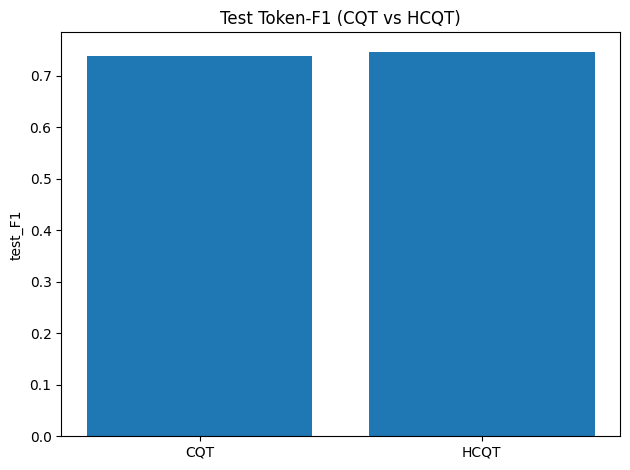

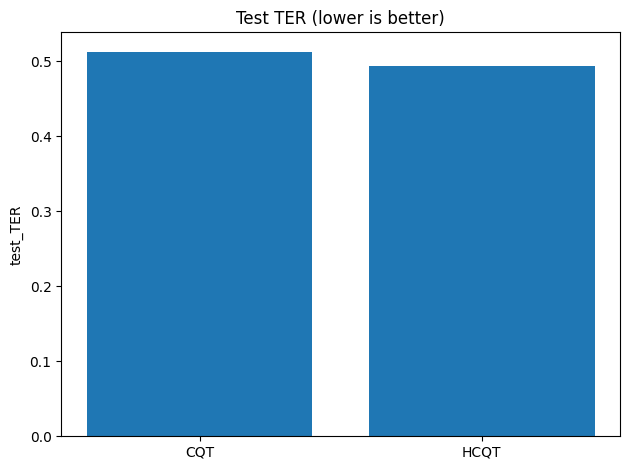

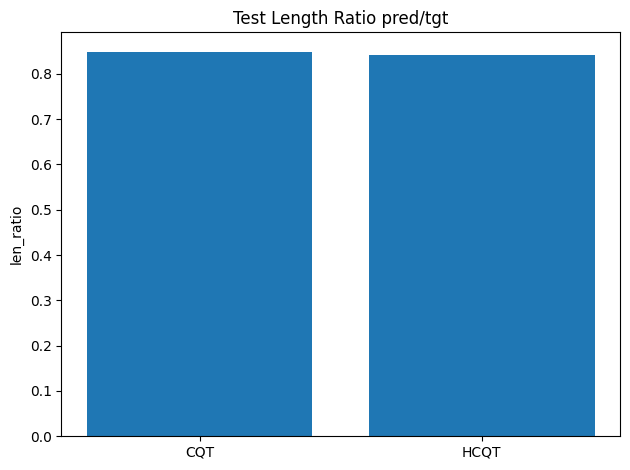

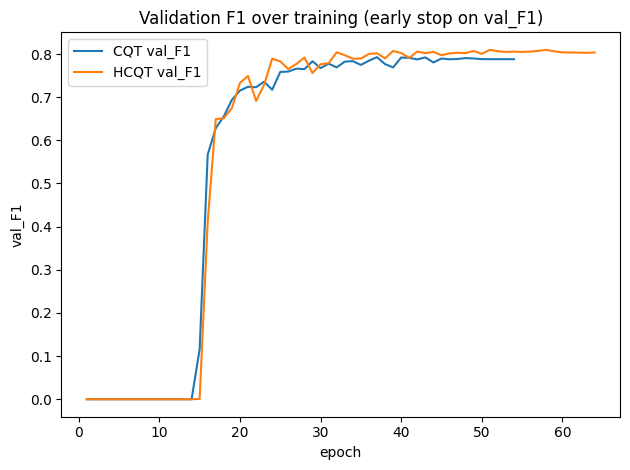

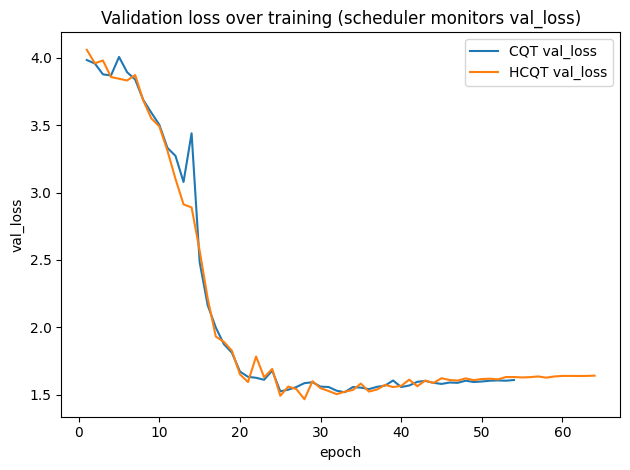

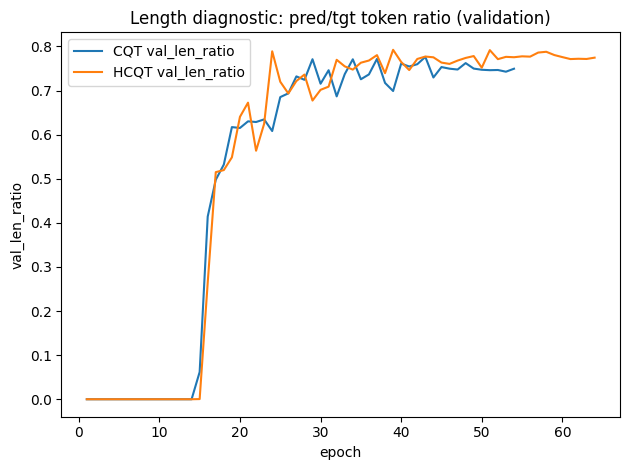

Saved figures to: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/figures


In [20]:
# ============================================
# BLOCK 12E: Presentation-ready comparison + plots (CQT vs HCQT)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

results = pd.read_csv(EXP_ROOT / "results_cqt_vs_hcqt_seed42.csv")

def mean_std_str(x):
    x = np.asarray(x, dtype=float)
    return f"{x.mean():.4f} ± {x.std():.4f}"

summary_table = []
for feat in ["cqt", "hcqt"]:
    df = results[results["feature"] == feat]
    summary_table.append({
        "feature": feat.upper(),
        "test_F1 (mean±std)": mean_std_str(df["test_F1"]),
        "test_TER (mean±std)": mean_std_str(df["test_TER"]),
        "test_len_ratio (mean±std)": mean_std_str(df["test_len_ratio"]),
        "best_epoch": int(df["best_epoch"].iloc[0]),
        "in_channels": int(df["in_channels"].iloc[0]),
    })

summary_df = pd.DataFrame(summary_table)
display(summary_df)
summary_df.to_csv(EXP_ROOT / "presentation_summary_table.csv", index=False)

# Bar plots
def bar(metric_col, title, ylabel, fname):
    vals = summary_df[metric_col].str.split().str[0].astype(float).values
    labs = summary_df["feature"].values
    plt.figure()
    plt.bar(labs, vals)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig(FIG_DIR / fname, dpi=160)
    plt.show()

bar("test_F1 (mean±std)", "Test Token-F1 (CQT vs HCQT)", "test_F1", "bar_test_f1.png")
bar("test_TER (mean±std)", "Test TER (lower is better)", "test_TER", "bar_test_ter.png")
bar("test_len_ratio (mean±std)", "Test Length Ratio pred/tgt", "len_ratio", "bar_test_len_ratio.png")

# Curves overlay
def load_hist(path): return pd.read_csv(path)

hists = {r["feature"]: load_hist(r["history_csv"]) for _, r in results.iterrows()}

plt.figure()
for feat, h in hists.items():
    plt.plot(h["epoch"], h["val_F1"], label=f"{feat.upper()} val_F1")
plt.title("Validation F1 over training (early stop on val_F1)")
plt.xlabel("epoch"); plt.ylabel("val_F1")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "curve_val_f1.png", dpi=160)
plt.show()

plt.figure()
for feat, h in hists.items():
    plt.plot(h["epoch"], h["val_loss"], label=f"{feat.upper()} val_loss")
plt.title("Validation loss over training (scheduler monitors val_loss)")
plt.xlabel("epoch"); plt.ylabel("val_loss")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "curve_val_loss.png", dpi=160)
plt.show()

plt.figure()
for feat, h in hists.items():
    plt.plot(h["epoch"], h["val_len_ratio"], label=f"{feat.upper()} val_len_ratio")
plt.title("Length diagnostic: pred/tgt token ratio (validation)")
plt.xlabel("epoch"); plt.ylabel("val_len_ratio")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "curve_val_len_ratio.png", dpi=160)
plt.show()

print("Saved figures to:", FIG_DIR)


Chosen feature: hcqt
Chosen ckpt   : /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/checkpoints/best_hcqt_noaug_seed42.pt
[manifest] manifest_hcqt.csv | hcqt: train=698 val=186 test=280
Saved per-segment predictions: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/test_preds_hcqt_seed42.csv


,feature,batch_idx,i_in_batch,track_id,seg_start_samp,npz_path,tgt_len,pred_len,len_ratio,TER,tok_P,tok_R,tok_F1,tgt_tokens,pred_tokens
0,hcqt,0,0,1759,0,,95,64,0.673684,0.547368,0.921875,0.621053,0.742138,"[27, 42, 54, 34, 29, 44, 56, 34, 30, 46, 58, 3...","[27, 42, 29, 44, 34, 30, 30, 30, 42, 46, 34, 3..."
1,hcqt,0,1,1759,220500,,127,92,0.724409,0.527559,0.891304,0.645669,0.748858,"[34, 32, 46, 58, 34, 30, 48, 60, 34, 29, 50, 6...","[27, 32, 34, 29, 32, 48, 34, 29, 34, 50, 62, 3..."
2,hcqt,0,2,1759,441000,,129,80,0.620155,0.511628,0.925000,0.573643,0.708134,"[25, 18, 42, 54, 25, 13, 37, 42, 46, 25, 27, 2...","[18, 30, 18, 25, 30, 25, 44, 27, 39, 42, 47, 2..."
3,hcqt,0,3,1759,661500,,128,82,0.640625,0.562500,0.865854,0.554687,0.676190,"[34, 39, 34, 27, 42, 54, 34, 32, 46, 58, 34, 3...","[34, 39, 27, 32, 34, 29, 32, 48, 34, 29, 50, 6..."
4,hcqt,0,4,1759,882000,,119,68,0.571429,0.596639,0.838235,0.478992,0.609626,"[25, 20, 41, 53, 25, 18, 42, 54, 25, 13, 37, 4...","[25, 20, 53, 25, 18, 30, 42, 18, 25, 30, 27, 2..."



Worst by TER:


,track_id,seg_start_samp,TER,tok_F1,tgt_len,pred_len,len_ratio,npz_path
104,2106,7276500,2.944444,0.345679,18,63,3.500000,
103,2106,7056000,2.000000,0.447059,25,60,2.400000,
179,2303,3528000,1.750000,0.592593,8,19,2.375000,
201,2382,4630500,1.000000,0.336842,46,49,1.065217,
105,2106,7497000,0.963636,0.677419,55,69,1.254545,
200,2382,4410000,0.871795,0.436364,117,103,0.880342,
198,2382,3969000,0.869110,0.383721,191,153,0.801047,
197,2382,3748500,0.855769,0.367568,208,162,0.778846,
199,2382,4189500,0.835979,0.435294,189,151,0.798942,
195,2382,3307500,0.820000,0.486486,100,85,0.850000,



Worst by token-F1:


,track_id,seg_start_samp,TER,tok_F1,tgt_len,pred_len,len_ratio,npz_path
201,2382,4630500,1.000000,0.336842,46,49,1.065217,
104,2106,7276500,2.944444,0.345679,18,63,3.500000,
197,2382,3748500,0.855769,0.367568,208,162,0.778846,
198,2382,3969000,0.869110,0.383721,191,153,0.801047,
196,2382,3528000,0.820000,0.387283,200,146,0.730000,
199,2382,4189500,0.835979,0.435294,189,151,0.798942,
200,2382,4410000,0.871795,0.436364,117,103,0.880342,
103,2106,7056000,2.000000,0.447059,25,60,2.400000,
195,2382,3307500,0.820000,0.486486,100,85,0.850000,
180,2382,0,0.680851,0.517647,141,114,0.808511,



Worst by length ratio (collapse):


,track_id,seg_start_samp,TER,tok_F1,tgt_len,pred_len,len_ratio,npz_path
240,2556,2646000,0.578313,0.619048,83,43,0.518072,
239,2556,2425500,0.580000,0.565789,100,52,0.520000,
192,2382,2646000,0.680000,0.579926,175,94,0.537143,
238,2556,2205000,0.542857,0.597561,105,59,0.561905,
32,1759,7056000,0.591667,0.648936,120,68,0.566667,
49,1819,2646000,0.568182,0.608696,44,25,0.568182,
4,1759,882000,0.596639,0.609626,119,68,0.571429,
256,2556,6174000,0.576923,0.609756,52,30,0.576923,
254,2556,5733000,0.536585,0.646154,123,72,0.585366,
31,1759,6835500,0.548387,0.696970,124,74,0.596774,


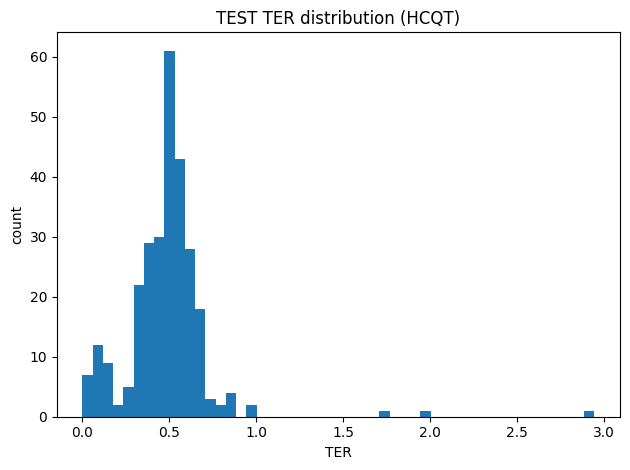

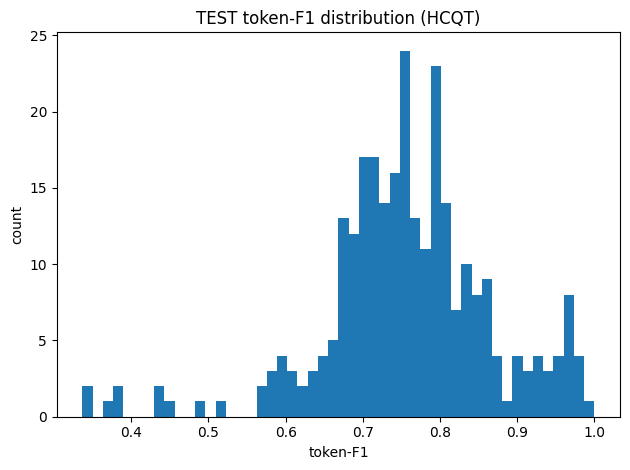

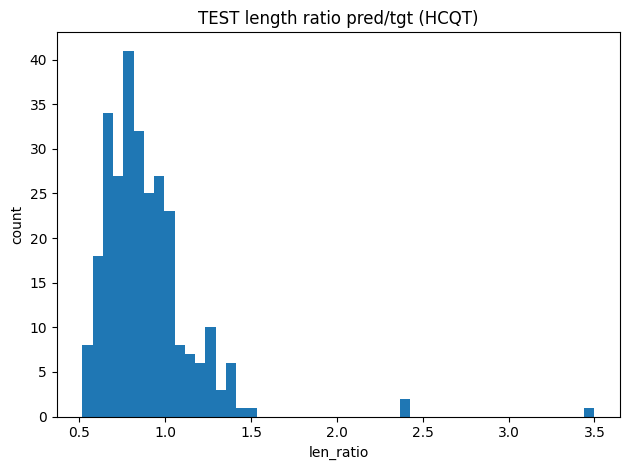

In [21]:
# ============================================
# BLOCK 13A: Collect per-segment predictions on TEST (chosen run)
# - Runs CTC forward on each test segment
# - Saves per-segment: target/pred tokens, losses proxy, TER, F1, lengths
# - Extracts "worst" examples by TER and by low F1 and by length collapse
# ============================================

import json, math, time
import numpy as np
import pandas as pd
from collections import Counter
import torch
import matplotlib.pyplot as plt

# ---- helper: edit distance + backtrace (for later blocks too) ----
def levenshtein_backtrace(a, b):
    """
    a = pred seq (list[int]), b = tgt seq (list[int])
    Returns:
      dist, ops where ops is list of (op, pred_token_or_None, tgt_token_or_None)
      op in {"match","sub","ins","del"}
    """
    n, m = len(a), len(b)
    dp = np.zeros((n+1, m+1), dtype=np.int32)
    bt = np.zeros((n+1, m+1), dtype=np.int8)  # 0 diag, 1 up (del), 2 left (ins)

    for i in range(1, n+1):
        dp[i, 0] = i
        bt[i, 0] = 1
    for j in range(1, m+1):
        dp[0, j] = j
        bt[0, j] = 2

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            diag = dp[i-1, j-1] + cost
            up   = dp[i-1, j] + 1
            left = dp[i, j-1] + 1
            best = min(diag, up, left)
            dp[i, j] = best
            if best == diag:
                bt[i, j] = 0
            elif best == up:
                bt[i, j] = 1
            else:
                bt[i, j] = 2

    # backtrace
    i, j = n, m
    ops = []
    while i > 0 or j > 0:
        move = bt[i, j] if (i > 0 and j > 0) else (1 if i > 0 else 2)
        if i > 0 and j > 0 and move == 0:
            if a[i-1] == b[j-1]:
                ops.append(("match", a[i-1], b[j-1]))
            else:
                ops.append(("sub", a[i-1], b[j-1]))
            i -= 1; j -= 1
        elif i > 0 and (j == 0 or move == 1):
            ops.append(("del", a[i-1], None))
            i -= 1
        else:
            ops.append(("ins", None, b[j-1]))
            j -= 1

    ops.reverse()
    return int(dp[n, m]), ops

def bag_token_f1(pred, tgt):
    """
    Bag-of-tokens micro F1 for one sample (counts, ignores order).
    """
    ct = Counter(tgt)
    cp = Counter(pred)
    tokens = set(ct) | set(cp)
    tp = fp = fn = 0
    for t in tokens:
        if t in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID):
            continue
        tp += min(ct.get(t, 0), cp.get(t, 0))
        fp += max(0, cp.get(t, 0) - ct.get(t, 0))
        fn += max(0, ct.get(t, 0) - cp.get(t, 0))
    p = tp / (tp + fp + 1e-12)
    r = tp / (tp + fn + 1e-12)
    f1 = 2*p*r / (p + r + 1e-12)
    return p, r, f1

# ---- choose which run to analyze ----
results_path = EXP_ROOT / "results_cqt_vs_hcqt_seed42.csv"
results = pd.read_csv(results_path)

# pick best by test_F1 (or choose manually: "cqt" / "hcqt")
best_row = results.sort_values("test_F1", ascending=False).iloc[0]
FEATURE_CHOSEN = str(best_row["feature"])
CKPT_CHOSEN = str(best_row["ckpt"])
print("Chosen feature:", FEATURE_CHOSEN)
print("Chosen ckpt   :", CKPT_CHOSEN)

# build loaders
_, _, test_loader = get_feature_loaders(FEATURE_CHOSEN, batch_size=16)

# build model with correct in_channels + F bins inferred from one batch
b0 = next(iter(test_loader))
in_channels, n_freq_bins = infer_channels_and_freqbins(b0["X"], max_reasonable_channels=16)
encoder = CNNBiLSTMEncoder(n_freq_bins=n_freq_bins, in_channels=in_channels).to(DEVICE)
model = CTCTranscriber(encoder, vocab_size=TOTAL_VOCAB_SIZE).to(DEVICE)
model.load_state_dict(torch.load(CKPT_CHOSEN, map_location=DEVICE))
model.eval()

rows = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        X = batch["X"].to(DEVICE, non_blocking=True)
        x_lens = batch["x_lens"].to(DEVICE, non_blocking=True)
        y = batch["y"].to(DEVICE, non_blocking=True)
        y_lens = batch["y_lens"].to(DEVICE, non_blocking=True)

        log_probs, out_lens = model(X, x_lens)
        # greedy decode (sequence-level)
        preds = greedy_ctc_decode(log_probs, out_lens)

        # per-sample stats
        B = X.shape[0]
        for i in range(B):
            tgt = y[i, :y_lens[i]].tolist()
            pred = preds[i]

            dist, _ = levenshtein_backtrace(pred, tgt)
            ter = dist / max(1, len(tgt))
            p, r, f1 = bag_token_f1(pred, tgt)

            # meta
            meta_i = batch["meta"][i] if "meta" in batch else {}
            # try to capture npz_path if provided somewhere
            npz_path = meta_i.get("npz_path", meta_i.get("path", ""))
            track_id = meta_i.get("track_id", None)
            seg_start = meta_i.get("seg_start_samp", None)

            rows.append({
                "feature": FEATURE_CHOSEN,
                "batch_idx": batch_idx,
                "i_in_batch": i,
                "track_id": track_id,
                "seg_start_samp": seg_start,
                "npz_path": npz_path,
                "tgt_len": len(tgt),
                "pred_len": len(pred),
                "len_ratio": (len(pred) / max(1, len(tgt))),
                "TER": ter,
                "tok_P": p,
                "tok_R": r,
                "tok_F1": f1,
                "tgt_tokens": json.dumps(tgt),
                "pred_tokens": json.dumps(pred),
            })

pred_df = pd.DataFrame(rows)
out_csv = EXP_ROOT / f"test_preds_{FEATURE_CHOSEN}_seed42.csv"
pred_df.to_csv(out_csv, index=False)
print("Saved per-segment predictions:", out_csv)
display(pred_df.head())

# ---- worst segments ----
worst_by_ter = pred_df.sort_values("TER", ascending=False).head(15)
worst_by_f1  = pred_df.sort_values("tok_F1", ascending=True).head(15)
worst_by_len = pred_df.sort_values("len_ratio", ascending=True).head(15)  # collapse

print("\nWorst by TER:")
display(worst_by_ter[["track_id","seg_start_samp","TER","tok_F1","tgt_len","pred_len","len_ratio","npz_path"]])

print("\nWorst by token-F1:")
display(worst_by_f1[["track_id","seg_start_samp","TER","tok_F1","tgt_len","pred_len","len_ratio","npz_path"]])

print("\nWorst by length ratio (collapse):")
display(worst_by_len[["track_id","seg_start_samp","TER","tok_F1","tgt_len","pred_len","len_ratio","npz_path"]])

# ---- slide-ready histogram plots ----
plt.figure()
plt.hist(pred_df["TER"].values, bins=50)
plt.title(f"TEST TER distribution ({FEATURE_CHOSEN.upper()})")
plt.xlabel("TER"); plt.ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / f"hist_test_TER_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()

plt.figure()
plt.hist(pred_df["tok_F1"].values, bins=50)
plt.title(f"TEST token-F1 distribution ({FEATURE_CHOSEN.upper()})")
plt.xlabel("token-F1"); plt.ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / f"hist_test_F1_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()

plt.figure()
plt.hist(pred_df["len_ratio"].values, bins=50)
plt.title(f"TEST length ratio pred/tgt ({FEATURE_CHOSEN.upper()})")
plt.xlabel("len_ratio"); plt.ylabel("count")
plt.tight_layout()
plt.savefig(FIG_DIR / f"hist_test_len_ratio_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()


Saved: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/top_substitutions_hcqt.csv


,pred_token,tgt_token,pred_note,tgt_note,count
0,37,25,58,46,37
1,46,44,67,65,34
2,41,44,62,65,34
3,47,44,68,65,25
4,30,42,51,63,23
5,30,18,51,39,23
6,46,42,67,63,23
7,34,37,55,58,22
8,41,29,62,50,22
9,47,42,68,63,21



Most often MISSING notes (model failed to output):


,tgt_note,count
0,58,266
1,63,233
2,55,228
3,65,228
4,46,185
5,62,184
6,70,177
7,67,168
8,79,159
9,74,150



Most often EXTRA notes (model hallucinated):


,pred_note,count
0,79,106
1,72,103
2,55,101
3,67,96
4,62,79
5,74,69
6,69,58
7,75,53
8,65,46
9,53,43


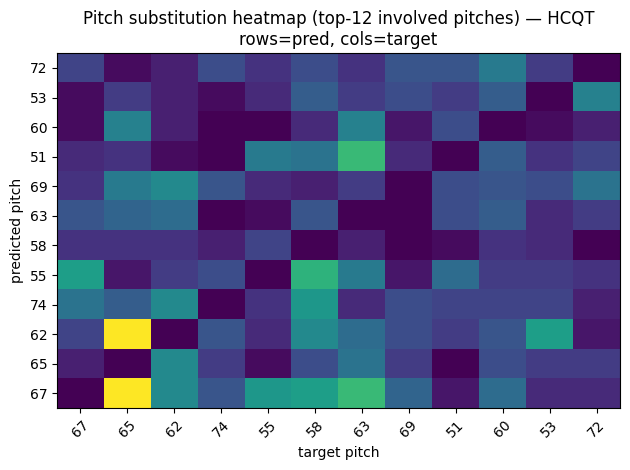

In [22]:
# ============================================
# BLOCK 13B: Pitch confusions (substitutions) from Levenshtein backtrace
# - Uses per-segment preds saved in 13A
# - Aggregates substitution counts pred->tgt for pitch tokens only
# - Produces top confusions table + optional heatmap for top-K pitches
# ============================================

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

pred_df = pd.read_csv(EXP_ROOT / f"test_preds_{FEATURE_CHOSEN}_seed42.csv")

sub_counts = Counter()
ins_counts = Counter()   # missing notes (insert in tgt)
del_counts = Counter()   # extra notes (delete from pred)

for _, r in pred_df.iterrows():
    pred = json.loads(r["pred_tokens"])
    tgt  = json.loads(r["tgt_tokens"])
    _, ops = levenshtein_backtrace(pred, tgt)

    for op, p_tok, t_tok in ops:
        if op == "sub":
            if (p_tok is not None) and (t_tok is not None):
                # ignore specials
                if p_tok in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID): 
                    continue
                if t_tok in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID): 
                    continue
                sub_counts[(p_tok, t_tok)] += 1
        elif op == "ins":
            if t_tok is not None and t_tok not in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID):
                ins_counts[t_tok] += 1
        elif op == "del":
            if p_tok is not None and p_tok not in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID):
                del_counts[p_tok] += 1

# Top substitutions
top_sub = sub_counts.most_common(30)
top_sub_df = pd.DataFrame([
    {
        "pred_token": a,
        "tgt_token": b,
        "pred_note": id_to_note(a),
        "tgt_note": id_to_note(b),
        "count": c
    }
    for (a,b), c in top_sub
])

out_sub_csv = EXP_ROOT / f"top_substitutions_{FEATURE_CHOSEN}.csv"
top_sub_df.to_csv(out_sub_csv, index=False)
print("Saved:", out_sub_csv)
display(top_sub_df)

# Top missing/extra notes
top_missing = pd.DataFrame([{"tgt_note": id_to_note(t), "count": c} for t,c in ins_counts.most_common(20)])
top_extra   = pd.DataFrame([{"pred_note": id_to_note(t), "count": c} for t,c in del_counts.most_common(20)])

print("\nMost often MISSING notes (model failed to output):")
display(top_missing)

print("\nMost often EXTRA notes (model hallucinated):")
display(top_extra)

# Optional heatmap for top-K involved pitches
K = 12
involved = Counter()
for (a,b), c in sub_counts.items():
    involved[a] += c
    involved[b] += c
top_pitches = [t for t,_ in involved.most_common(K)]
top_notes = [id_to_note(t) for t in top_pitches]

mat = np.zeros((K, K), dtype=np.int32)
idx = {t:i for i,t in enumerate(top_pitches)}
for (a,b), c in sub_counts.items():
    if a in idx and b in idx:
        mat[idx[a], idx[b]] += c

plt.figure()
plt.imshow(mat, aspect="auto", origin="lower")
plt.title(f"Pitch substitution heatmap (top-{K} involved pitches) — {FEATURE_CHOSEN.upper()}\nrows=pred, cols=target")
plt.xticks(range(K), top_notes, rotation=45)
plt.yticks(range(K), top_notes)
plt.xlabel("target pitch"); plt.ylabel("predicted pitch")
plt.tight_layout()
plt.savefig(FIG_DIR / f"heatmap_top_subs_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()


Chosen example row:


,feature,batch_idx,i_in_batch,track_id,seg_start_samp,npz_path,tgt_len,pred_len,len_ratio,TER,tok_P,tok_R,tok_F1,tgt_tokens,pred_tokens
104,hcqt,6,8,2106,7276500,NaN,18,63,3.5,2.944444,0.222222,0.777778,0.345679,"[29, 34, 40, 43, 41, 45, 29, 34, 43, 46, 45, 4...","[41, 29, 45, 29, 46, 29, 48, 29, 34, 46, 31, 5..."


[manifest] manifest_hcqt.csv | hcqt: train=698 val=186 test=280


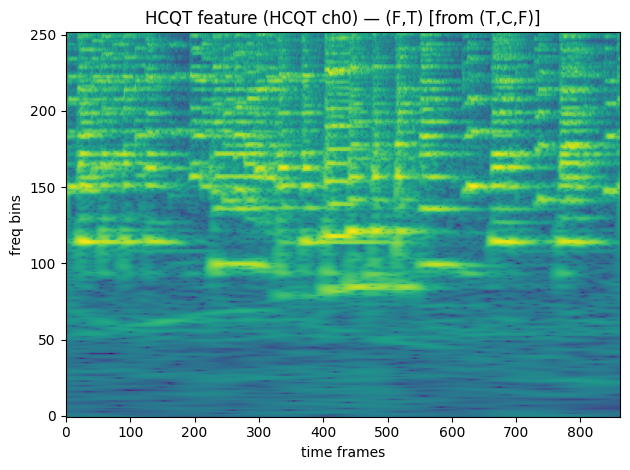

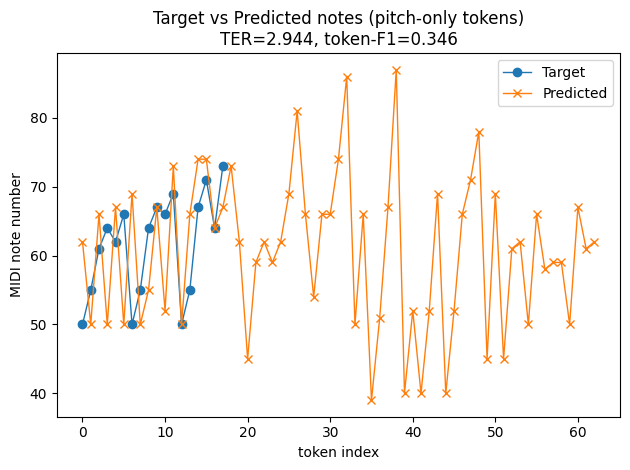

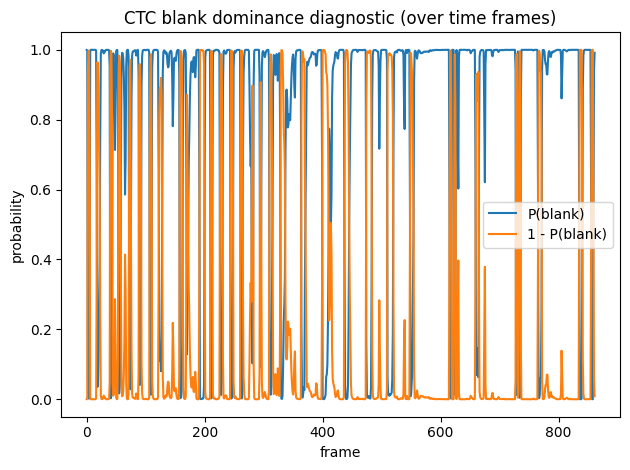

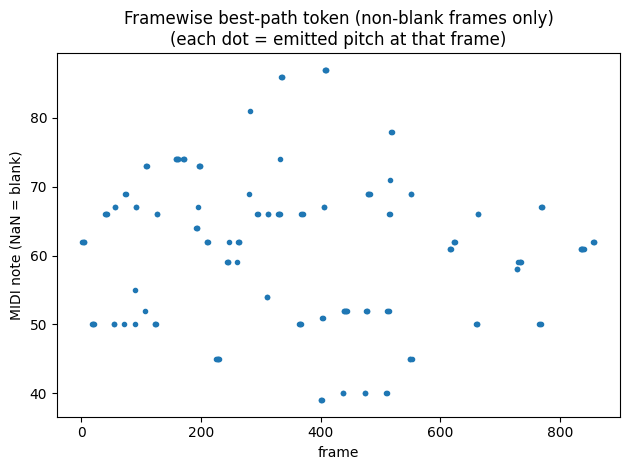


Meta for this segment: {'track_id': 2106, 'split': 'test', 'audio_path': '/home/jovyan/work/musicnet_small/test_data/2106.wav', 'label_path': '/home/jovyan/work/musicnet_small/test_labels/2106.csv', 'seg_start_samp': 7276500, 'seg_end_samp': 7717500, 'sr': 44100, 'hop_length': 512, 'bins_per_octave': 36, 'n_bins': 252, 'fmin': 32.7031956626, 'token_type': 'pitch_only', 'min_note': 21, 'max_note': 108, 'feature_type': 'hcqt', 'hcqt_harmonics': [0.5, 1.0, 2.0, 3.0, 4.0]}

Target notes: [50, 55, 61, 64, 62, 66, 50, 55, 64, 67, 66, 69, 50, 55, 67, 71, 64, 73] 
Pred notes  : [62, 50, 66, 50, 67, 50, 69, 50, 55, 67, 52, 73, 50, 66, 74, 74, 64, 67, 73, 62, 45, 59, 62, 59, 62, 69, 81, 66, 54, 66, 66, 74, 86, 50, 66, 39, 51, 67, 87, 40, 52, 40, 52, 69, 40, 52, 66, 71, 78, 45, 69, 45, 61, 62, 50, 66, 58, 59, 59, 50] ...


In [23]:
# ============================================
# BLOCK 13C: Qualitative "worst segment" visualization
# - Picks one segment (e.g., worst TER) from 13A outputs
# - Loads the segment features from the batch (no need to reload NPZ)
# - Plots:
#   (1) Feature image (CQT or HCQT: show channel 0 if HCQT)
#   (2) Target vs Pred notes (token sequences)
#   (3) Blank probability over time + emitted token over time (best path)
# ============================================

import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

pred_df = pd.read_csv(EXP_ROOT / f"test_preds_{FEATURE_CHOSEN}_seed42.csv")

# Choose example: worst TER (change to "tok_F1" if desired)
ex = pred_df.sort_values("TER", ascending=False).iloc[0]
print("Chosen example row:")
display(ex.to_frame().T)

ex_batch_idx = int(ex["batch_idx"])
ex_i = int(ex["i_in_batch"])

# Rebuild test_loader and model (consistent)
_, _, test_loader = get_feature_loaders(FEATURE_CHOSEN, batch_size=16)
b0 = next(iter(test_loader))
in_channels, n_freq_bins = infer_channels_and_freqbins(b0["X"], max_reasonable_channels=16)

encoder = CNNBiLSTMEncoder(n_freq_bins=n_freq_bins, in_channels=in_channels).to(DEVICE)
model = CTCTranscriber(encoder, vocab_size=TOTAL_VOCAB_SIZE).to(DEVICE)
model.load_state_dict(torch.load(CKPT_CHOSEN, map_location=DEVICE))
model.eval()

# Fetch the exact batch again
batch = None
for bi, b in enumerate(test_loader):
    if bi == ex_batch_idx:
        batch = b
        break
assert batch is not None, "Could not retrieve batch (batch index out of range)."

# Pull one sample
X = batch["X"][ex_i:ex_i+1].to(DEVICE)
x_lens = batch["x_lens"][ex_i:ex_i+1].to(DEVICE)
y = batch["y"][ex_i].cpu().numpy()
y_len = int(batch["y_lens"][ex_i].item())
meta_i = batch["meta"][ex_i] if "meta" in batch else {}

tgt_tokens = y[:y_len].tolist()
tgt_notes = [id_to_note(t) for t in tgt_tokens]

with torch.no_grad():
    log_probs, out_lens = model(X, x_lens)  # (1,T,V)
    T = int(out_lens[0].item())
    lp = log_probs[0, :T].detach().cpu()  # (T,V)

# Best path (framewise argmax)
best_path = lp.argmax(dim=-1).numpy().tolist()
# Collapse (greedy CTC)
collapsed = []
prev = None
for s in best_path:
    if s != prev:
        collapsed.append(s)
    prev = s
pred_tokens = [t for t in collapsed if t not in (CTC_BLANK_ID, PAD_ID, SOS_ID, EOS_ID)]
pred_notes = [id_to_note(t) for t in pred_tokens]

# Blank probability over time
blank_prob = lp[:, CTC_BLANK_ID].exp().numpy()

# Non-blank "confidence" = 1 - P(blank)
speak_prob = 1.0 - blank_prob

# For visualization: show emitted token (best_path) but map blanks to NaN
emitted = []
for t in best_path:
    if t == CTC_BLANK_ID:
        emitted.append(np.nan)
    elif t in (PAD_ID, SOS_ID, EOS_ID):
        emitted.append(np.nan)
    else:
        emitted.append(id_to_note(t))

# ---- Plot 1: feature image ----
X_cpu = batch["X"][ex_i].cpu().numpy()
# X_cpu can be (T,F) for CQT, or (C,T,F) or (T,C,F) depending on HCQT pipeline
# We plot one channel view:
if X_cpu.ndim == 2:
    feat_img = X_cpu.T  # (F,T)
    title_feat = f"{FEATURE_CHOSEN.upper()} feature (CQT) — (F,T)"
elif X_cpu.ndim == 3:
    # try interpret as (C,T,F) if first dim small, else (T,C,F)
    if X_cpu.shape[0] <= 16:
        feat_img = X_cpu[0].T  # channel 0 -> (F,T)
        title_feat = f"{FEATURE_CHOSEN.upper()} feature (HCQT ch0) — (F,T)"
    else:
        feat_img = X_cpu[:, 0, :].T  # (T,F) from (T,C,F) take ch0 -> (F,T)
        title_feat = f"{FEATURE_CHOSEN.upper()} feature (HCQT ch0) — (F,T) [from (T,C,F)]"
else:
    raise ValueError(f"Unexpected feature shape for plotting: {X_cpu.shape}")

plt.figure()
plt.imshow(feat_img, aspect="auto", origin="lower")
plt.title(title_feat)
plt.xlabel("time frames"); plt.ylabel("freq bins")
plt.tight_layout()
plt.savefig(FIG_DIR / f"qual_feat_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()

# ---- Plot 2: target vs predicted note sequences ----
plt.figure()
plt.plot(tgt_notes, marker="o", linewidth=1, label="Target")
plt.plot(pred_notes, marker="x", linewidth=1, label="Predicted")
plt.title(f"Target vs Predicted notes (pitch-only tokens)\nTER={float(ex['TER']):.3f}, token-F1={float(ex['tok_F1']):.3f}")
plt.xlabel("token index"); plt.ylabel("MIDI note number")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / f"qual_seq_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()

# ---- Plot 3: blank probability + emitted token over frames ----
plt.figure()
plt.plot(blank_prob, label="P(blank)")
plt.plot(speak_prob, label="1 - P(blank)")
plt.title("CTC blank dominance diagnostic (over time frames)")
plt.xlabel("frame"); plt.ylabel("probability")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / f"qual_blankprob_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()

plt.figure()
plt.plot(emitted, marker=".", linewidth=0)
plt.title("Framewise best-path token (non-blank frames only)\n(each dot = emitted pitch at that frame)")
plt.xlabel("frame"); plt.ylabel("MIDI note (NaN = blank)")
plt.tight_layout()
plt.savefig(FIG_DIR / f"qual_emitted_{FEATURE_CHOSEN}.png", dpi=160)
plt.show()

print("\nMeta for this segment:", meta_i)
print("\nTarget notes:", tgt_notes[:60], "..." if len(tgt_notes)>60 else "")
print("Pred notes  :", pred_notes[:60], "..." if len(pred_notes)>60 else "")


In [24]:
# ============================================
# BLOCK 13B (REPLACEMENT): Pitch Confusion Matrix (no heatmap)
# - Uses Levenshtein backtrace from BLOCK 13A helper
# - Confusion matrix counts substitutions: pred_token -> tgt_token
# - Exports:
#   (1) confusion_matrix_counts.csv  (88x88)
#   (2) confusion_matrix_row_norm.csv (optional)
#   (3) top_substitutions.csv
# - Also prints top confusions and some matrix slices for slides
# ============================================

import json
import numpy as np
import pandas as pd
from collections import Counter

# Load per-segment predictions produced in BLOCK 13A
pred_df = pd.read_csv(EXP_ROOT / f"test_preds_{FEATURE_CHOSEN}_seed42.csv")

# Token set: pitch-only tokens are 0..87 (88 pitches)
PITCH_TOKENS = list(range(N_PITCH))
PITCH_NOTES  = [id_to_note(t) for t in PITCH_TOKENS]

# Confusion matrix counts: rows=pred pitch token, cols=target pitch token
cm = np.zeros((N_PITCH, N_PITCH), dtype=np.int64)

# Track insertions/deletions (not in matrix, but useful diagnostics)
ins_counts = Counter()  # missing notes (present in target but not predicted at aligned spot)
del_counts = Counter()  # extra notes (predicted but not in target at aligned spot)
sub_counts = Counter()  # (pred,tgt)->count

for _, r in pred_df.iterrows():
    pred = json.loads(r["pred_tokens"])
    tgt  = json.loads(r["tgt_tokens"])

    # backtrace operations from earlier helper
    _, ops = levenshtein_backtrace(pred, tgt)

    for op, p_tok, t_tok in ops:
        if op == "sub":
            if p_tok is None or t_tok is None:
                continue
            if (p_tok in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID)) or (t_tok in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID)):
                continue
            # Only keep pitch tokens
            if (0 <= p_tok < N_PITCH) and (0 <= t_tok < N_PITCH):
                cm[p_tok, t_tok] += 1
                sub_counts[(p_tok, t_tok)] += 1

        elif op == "ins":
            # insertion means token in target that wasn't matched (model missed it)
            if t_tok is None:
                continue
            if (t_tok not in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID)) and (0 <= t_tok < N_PITCH):
                ins_counts[t_tok] += 1

        elif op == "del":
            # deletion means token in pred that wasn't matched (model hallucinated)
            if p_tok is None:
                continue
            if (p_tok not in (PAD_ID, CTC_BLANK_ID, SOS_ID, EOS_ID)) and (0 <= p_tok < N_PITCH):
                del_counts[p_tok] += 1

# ---- Build DataFrames (counts and normalized variants) ----
cm_counts_df = pd.DataFrame(cm, index=[f"pred_{n}" for n in PITCH_NOTES],
                               columns=[f"tgt_{n}" for n in PITCH_NOTES])

# Row-normalized: for each predicted pitch, distribution over targets
row_sums = cm.sum(axis=1, keepdims=True)
cm_row_norm = cm / np.maximum(row_sums, 1)
cm_row_norm_df = pd.DataFrame(cm_row_norm, index=cm_counts_df.index, columns=cm_counts_df.columns)

# Column-normalized: for each target pitch, what it gets confused with
col_sums = cm.sum(axis=0, keepdims=True)
cm_col_norm = cm / np.maximum(col_sums, 1)
cm_col_norm_df = pd.DataFrame(cm_col_norm, index=cm_counts_df.index, columns=cm_counts_df.columns)

# ---- Save outputs ----
out_counts = EXP_ROOT / f"confusion_matrix_counts_{FEATURE_CHOSEN}.csv"
out_row    = EXP_ROOT / f"confusion_matrix_row_norm_{FEATURE_CHOSEN}.csv"
out_col    = EXP_ROOT / f"confusion_matrix_col_norm_{FEATURE_CHOSEN}.csv"
cm_counts_df.to_csv(out_counts)
cm_row_norm_df.to_csv(out_row)
cm_col_norm_df.to_csv(out_col)

print("Saved confusion matrices:")
print(" -", out_counts)
print(" -", out_row)
print(" -", out_col)

# ---- Top confusions table (exclude correct = diagonal) ----
top_sub = []
for (p_tok, t_tok), c in sub_counts.items():
    if p_tok == t_tok:
        continue
    top_sub.append((c, p_tok, t_tok))
top_sub.sort(reverse=True)

topK = 30
top_sub_df = pd.DataFrame(
    [{"count": c,
      "pred_token": p_tok, "tgt_token": t_tok,
      "pred_note": id_to_note(p_tok), "tgt_note": id_to_note(t_tok)}
     for c, p_tok, t_tok in top_sub[:topK]]
)

out_top = EXP_ROOT / f"top_substitutions_{FEATURE_CHOSEN}.csv"
top_sub_df.to_csv(out_top, index=False)

print("\nTop substitutions (confusions):")
display(top_sub_df)

# ---- Also provide "most missed" and "most extra" notes ----
top_missing = pd.DataFrame([{"tgt_note": id_to_note(t), "count": c} for t, c in ins_counts.most_common(20)])
top_extra   = pd.DataFrame([{"pred_note": id_to_note(t), "count": c} for t, c in del_counts.most_common(20)])

print("\nMost often MISSING notes (insertions into target):")
display(top_missing)

print("\nMost often EXTRA notes (deletions from prediction):")
display(top_extra)

# ---- Slide-friendly: show a compact matrix for the most involved notes ----
# Pick pitches that appear in substitutions often (rows+cols), then show submatrix as a table
involved = Counter()
for (p_tok, t_tok), c in sub_counts.items():
    involved[p_tok] += c
    involved[t_tok] += c

K = 12
top_tokens = [t for t, _ in involved.most_common(K)]
top_notes = [id_to_note(t) for t in top_tokens]

sub_cm = cm[np.ix_(top_tokens, top_tokens)]
sub_cm_df = pd.DataFrame(sub_cm, index=[f"pred_{n}" for n in top_notes],
                              columns=[f"tgt_{n}" for n in top_notes])

print(f"\nConfusion matrix (substitutions) subtable for top-{K} involved pitches:")
display(sub_cm_df)

# Optional: save this smaller table too
out_small = EXP_ROOT / f"confusion_matrix_top{K}_{FEATURE_CHOSEN}.csv"
sub_cm_df.to_csv(out_small)
print("Saved small confusion matrix:", out_small)


Saved confusion matrices:
 - /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/confusion_matrix_counts_hcqt.csv
 - /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/confusion_matrix_row_norm_hcqt.csv
 - /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/confusion_matrix_col_norm_hcqt.csv

Top substitutions (confusions):


,count,pred_token,tgt_token,pred_note,tgt_note
0,37,37,25,58,46
1,34,46,44,67,65
2,34,41,44,62,65
3,25,47,44,68,65
4,23,46,42,67,63
5,23,30,42,51,63
6,23,30,18,51,39
7,22,41,29,62,50
8,22,34,37,55,58
9,21,47,42,68,63



Most often MISSING notes (insertions into target):


,tgt_note,count
0,58,266
1,63,233
2,55,228
3,65,228
4,46,185
5,62,184
6,70,177
7,67,168
8,79,159
9,74,150



Most often EXTRA notes (deletions from prediction):


,pred_note,count
0,79,106
1,72,103
2,55,101
3,67,96
4,62,79
5,74,69
6,69,58
7,75,53
8,65,46
9,53,43



Confusion matrix (substitutions) subtable for top-12 involved pitches:


,tgt_67,tgt_65,tgt_62,tgt_74,tgt_55,tgt_58,tgt_63,tgt_69,tgt_51,tgt_60,tgt_53,tgt_72
pred_67,0,34,16,9,18,19,23,11,2,12,4,4
pred_65,3,0,16,6,1,8,13,6,0,8,6,6
pred_62,7,34,0,9,4,16,12,8,6,9,19,2
pred_74,13,10,16,0,5,18,4,8,7,7,7,3
pred_55,19,2,6,8,0,22,14,2,12,6,6,5
pred_58,5,5,5,3,7,0,3,0,1,5,4,0
pred_63,9,11,12,0,1,9,0,0,8,10,4,6
pred_69,5,14,16,9,4,3,6,0,8,9,8,13
pred_51,4,5,1,0,14,13,23,4,0,10,5,7
pred_60,1,15,3,0,0,4,15,2,8,0,1,3


Saved small confusion matrix: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/confusion_matrix_top12_hcqt.csv


Loaded: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/confusion_matrix_counts_hcqt.csv | shape: (88, 88)


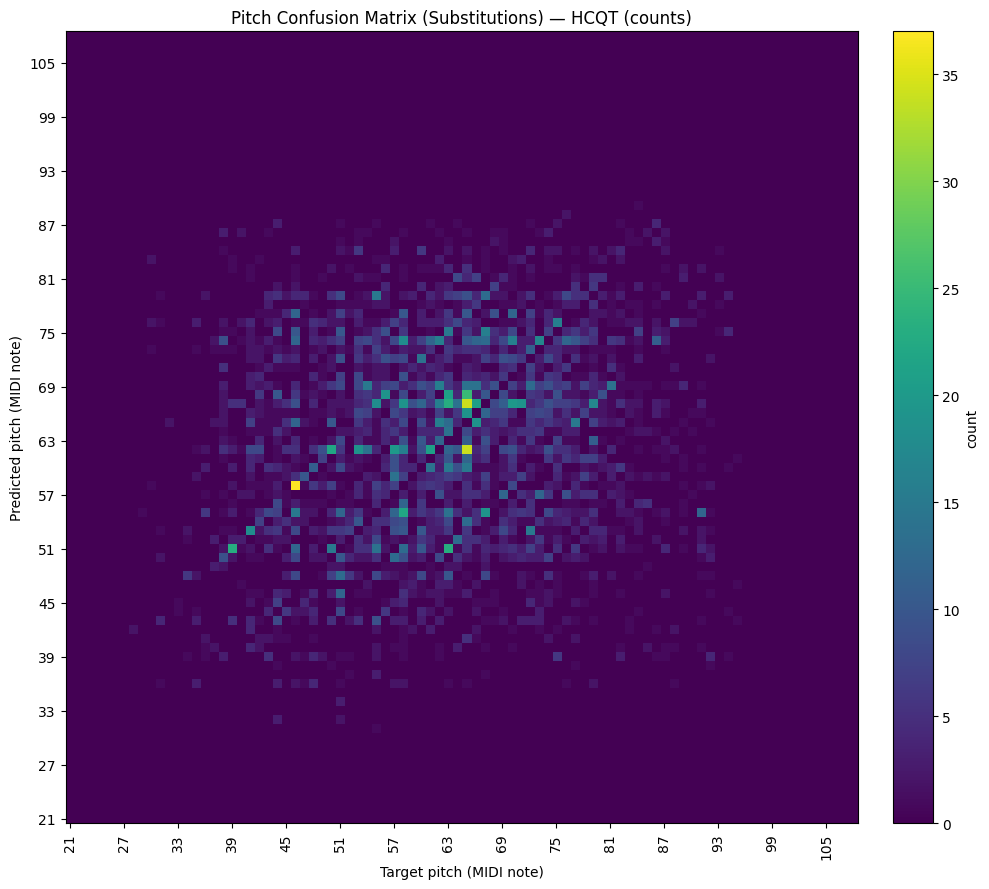

Saved full confusion matrix graph: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/figures/confusion_matrix_full_hcqt.png


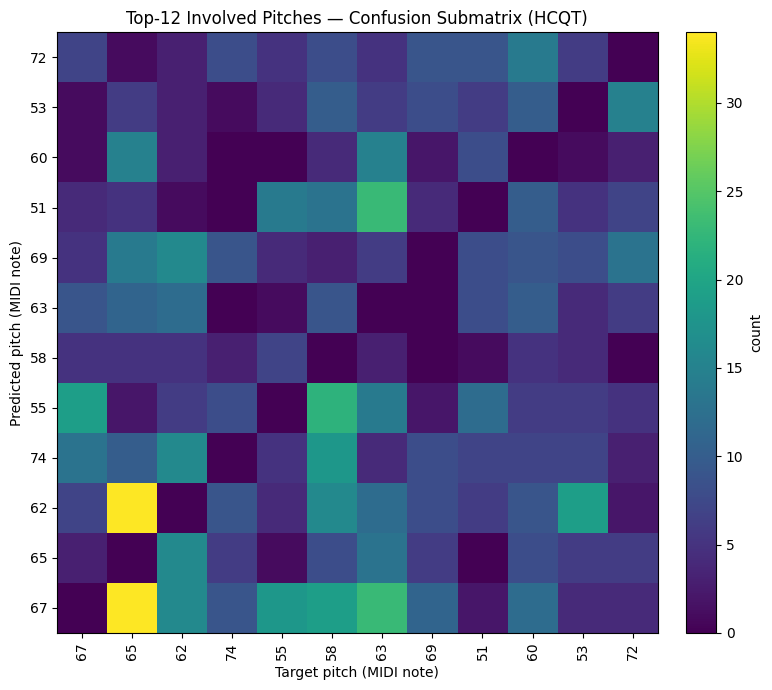

Saved top-K confusion matrix graph: /home/jovyan/shared/musicnet_experiments_ctc/experiments_cqt_vs_hcqt_noaug_seed42/figures/confusion_matrix_top12_hcqt.png


In [25]:
# ============================================
# BLOCK 13B-Plot: Confusion Matrix GRAPH (matplotlib, no seaborn)
# - Plots the (88x88) confusion matrix you saved in BLOCK 13B
# - Also plots a readable "top-K pitches" submatrix (recommended for slides)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load full confusion matrix (counts) ---
cm_path = EXP_ROOT / f"confusion_matrix_counts_{FEATURE_CHOSEN}.csv"
cm_df = pd.read_csv(cm_path, index_col=0)
cm = cm_df.values.astype(np.float32)

print("Loaded:", cm_path, "| shape:", cm.shape)

# ---------- Helper: nice tick labels (MIDI note numbers) ----------
# Your cm rows/cols are named like "pred_60", "tgt_61", ...
# We'll extract the MIDI numbers.
def _extract_note(label: str) -> int:
    # label like "pred_60" or "tgt_60"
    return int(label.split("_")[-1])

row_notes = [_extract_note(s) for s in cm_df.index.tolist()]
col_notes = [_extract_note(s) for s in cm_df.columns.tolist()]

# ---------- FULL MATRIX PLOT (88x88) ----------
plt.figure(figsize=(10, 9))
im = plt.imshow(cm, aspect="equal", origin="lower")  # default colormap
plt.title(f"Pitch Confusion Matrix (Substitutions) — {FEATURE_CHOSEN.upper()} (counts)")
plt.xlabel("Target pitch (MIDI note)")
plt.ylabel("Predicted pitch (MIDI note)")
plt.colorbar(im, fraction=0.046, pad=0.04, label="count")

# Reduce tick clutter: show every 6th note (approx half-octave steps in MIDI)
step = 6
xt = np.arange(0, len(col_notes), step)
yt = np.arange(0, len(row_notes), step)
plt.xticks(xt, [col_notes[i] for i in xt], rotation=90)
plt.yticks(yt, [row_notes[i] for i in yt])

plt.tight_layout()
full_fig = FIG_DIR / f"confusion_matrix_full_{FEATURE_CHOSEN}.png"
plt.savefig(full_fig, dpi=200)
plt.show()

print("Saved full confusion matrix graph:", full_fig)

# ---------- TOP-K SUBMATRIX PLOT (slide-friendly) ----------
# Use the small confusion matrix from BLOCK 13B if you saved it (recommended).
K = 12
small_path = EXP_ROOT / f"confusion_matrix_top{K}_{FEATURE_CHOSEN}.csv"

if small_path.exists():
    sub_df = pd.read_csv(small_path, index_col=0)
    sub_cm = sub_df.values.astype(np.float32)

    # Extract notes again from labels like "pred_60"
    sub_row_notes = [_extract_note(s) for s in sub_df.index.tolist()]
    sub_col_notes = [_extract_note(s) for s in sub_df.columns.tolist()]

    plt.figure(figsize=(8, 7))
    im2 = plt.imshow(sub_cm, aspect="equal", origin="lower")
    plt.title(f"Top-{K} Involved Pitches — Confusion Submatrix ({FEATURE_CHOSEN.upper()})")
    plt.xlabel("Target pitch (MIDI note)")
    plt.ylabel("Predicted pitch (MIDI note)")
    plt.colorbar(im2, fraction=0.046, pad=0.04, label="count")

    plt.xticks(np.arange(K), sub_col_notes, rotation=90)
    plt.yticks(np.arange(K), sub_row_notes)

    plt.tight_layout()
    sub_fig = FIG_DIR / f"confusion_matrix_top{K}_{FEATURE_CHOSEN}.png"
    plt.savefig(sub_fig, dpi=220)
    plt.show()

    print("Saved top-K confusion matrix graph:", sub_fig)

else:
    print("Top-K submatrix CSV not found:", small_path)
    print("Run BLOCK 13B (REPLACEMENT) first (it creates confusion_matrix_top12_<feature>.csv).")


In [30]:
# ============================================
# BLOCK 14F (FINAL REPLACEMENT): Worst vs Best segment gallery (rank by tok_F1)
# Your available columns:
# ['feature','batch_idx','i_in_batch','track_id','seg_start_samp','npz_path',
#  'tgt_len','pred_len','len_ratio','TER','tok_P','tok_R','tok_F1',
#  'tgt_tokens','pred_tokens']
#
# Produces:
# - 4 worst + 4 best segments by tok_F1
# - For each: feature image + printed target/pred notes + key metrics
# ============================================

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pred_df = pd.read_csv(EXP_ROOT / f"test_preds_{FEATURE_CHOSEN}_seed42.csv")

# ---- required columns (explicit, since we know your schema) ----
COL_F1   = "tok_F1"
COL_P    = "tok_P"
COL_R    = "tok_R"
COL_TER  = "TER"
COL_TRK  = "track_id"
COL_S0   = "seg_start_samp"
COL_NPZ  = "npz_path"
COL_TLEN = "tgt_len"
COL_PLEN = "pred_len"
COL_LR   = "len_ratio"
COL_TGT  = "tgt_tokens"
COL_PRED = "pred_tokens"

missing = [c for c in [COL_F1,COL_P,COL_R,COL_TER,COL_TRK,COL_S0,COL_NPZ,COL_TLEN,COL_PLEN,COL_LR,COL_TGT,COL_PRED] if c not in pred_df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}\nAvailable: {list(pred_df.columns)}")

# ---------- Feature to 2D image for plotting ----------
def load_feature_as_image(npz_path: str):
    z = np.load(npz_path, allow_pickle=False)
    X = z["X"]

    # return (T,F) for plotting as imshow(Ximg.T)
    if X.ndim == 2:
        # stored as (F,T) usually -> transpose
        if X.shape[0] in (252, 216, 360) and X.shape[1] > X.shape[0]:
            return X.T
        return X

    if X.ndim == 3:
        # HCQT typical: channels=5
        # handle (C,F,T) or (C,T,F) or (T,F,C)
        a,b,c = X.shape
        if a <= 8:  # channels-first
            if b in (252, 216, 360):      # (C,F,T)
                return X.mean(axis=0).T   # -> (T,F)
            if c in (252, 216, 360):      # (C,T,F)
                return X.mean(axis=0)     # -> (T,F)
            return X.mean(axis=0)
        if c <= 8:  # channels-last (T,F,C)
            return X.mean(axis=2)         # -> (T,F)

    return np.squeeze(X)

def tokens_to_notes(tok_list):
    # pitch-only tokens 0..87 -> MIDI notes 21..108
    return [id_to_note(int(t)) for t in tok_list if 0 <= int(t) < N_PITCH]

def shorten(seq, k=40):
    return seq if len(seq) <= k else (seq[:k] + ["…"])

# ---------- Select worst/best ----------
pred_df_sorted = pred_df.sort_values(COL_F1, ascending=True).reset_index(drop=True)
worst = pred_df_sorted.head(4)
best  = pred_df_sorted.tail(4)
gallery = pd.concat([worst, best], ignore_index=True)

print("Gallery rows:", len(gallery))
display(gallery[[COL_TRK, COL_S0, COL_F1, COL_P, COL_R, COL_TER, COL_PLEN, COL_TLEN, COL_LR, COL_NPZ]].reset_index(drop=True))

# ---------- Plot / print ----------
for i, r in gallery.iterrows():
    npz_path = r[COL_NPZ]
    Ximg = load_feature_as_image(npz_path)

    tgt_tok = json.loads(r[COL_TGT])
    pred_tok = json.loads(r[COL_PRED])

    tgt_notes = tokens_to_notes(tgt_tok)
    pred_notes = tokens_to_notes(pred_tok)

    trk = int(r[COL_TRK])
    s0  = int(r[COL_S0])
    f1  = float(r[COL_F1])
    p   = float(r[COL_P])
    rr  = float(r[COL_R])
    ter = float(r[COL_TER])
    plen = int(r[COL_PLEN])
    tlen = int(r[COL_TLEN])
    lr   = float(r[COL_LR])

    plt.figure(figsize=(10, 3.2))
    plt.imshow(Ximg.T, aspect="auto", origin="lower")
    plt.title(f"{FEATURE_CHOSEN.upper()} | track {trk} | start={s0} | tok_F1={f1:.3f} (P={p:.3f}, R={rr:.3f}) | TER={ter:.3f} | len={plen}/{tlen} (ratio={lr:.3f})")
    plt.xlabel("frames")
    plt.ylabel("freq bins")
    plt.tight_layout()
    plt.show()

    print("TARGET notes:", shorten(tgt_notes))
    print("PRED   notes:", shorten(pred_notes))
    print("-" * 110)


Gallery rows: 8


,track_id,seg_start_samp,tok_F1,tok_P,tok_R,TER,pred_len,tgt_len,len_ratio,npz_path
0,2382,4630500,0.336842,0.326531,0.347826,1.000000,49,46,1.065217,NaN
1,2106,7276500,0.345679,0.222222,0.777778,2.944444,63,18,3.500000,NaN
2,2382,3748500,0.367568,0.419753,0.326923,0.855769,162,208,0.778846,NaN
3,2382,3969000,0.383721,0.431373,0.345550,0.869110,153,191,0.801047,NaN
4,2303,220500,0.977528,1.000000,0.956044,0.043956,87,91,0.956044,NaN
5,2303,2425500,0.980392,0.990099,0.970874,0.038835,101,103,0.980583,NaN
6,2303,1984500,0.983051,0.977528,0.988636,0.034091,89,88,1.011364,NaN
7,2303,441000,1.000000,1.000000,1.000000,0.000000,90,90,1.000000,NaN


TypeError: expected str, bytes or os.PathLike object, not float